# Problem Statement

The Case Study “Predictive Equipment Failures” deals with prediction of the
failure of an equipment before it can fail. As an employee while working in
an MNC, we had been given the task of building IoT solutions for the
underlying infrastructure of the company. The entire IoT system was built
with sensors and connected over the Internet to Cloud to monitor readings,
control devices such as HVAC, Diesel Generators etc. The important point to
note is when a device like AC’s or diesel generator fail, the cost of repair at
that instant in an emergency is multiple times of the cost that it would take to
repair when done as maintenance. Such costs bring down revenue for the
company even though the company had the data before hand but was not
able to convert the same into useful information.

This case study exactly deals with a similar scenario as posed by a company
named “ConocoPhillips” in West Texas. The company has several oil wells
classified as stripper wells. Stripper wells produce low volumes of oil at well
level, but at a country level of the US, they amount for significant domestic
oil production. Since the wells have low throughput, if the equipment for
extracting the oil fails, then profit margin too is impacted severely. Thus, the
company has attached 107 sensors to the surface and down-hole equipment
and provided a dataset of the values and the downtime of the equipment.
Using the dataset, we need to predict if the equipment will fail in the near
future. This would help the company in sending the maintenance team to
the well location to fix the equipment on the surface level or even send a
worker rig to the well to pull-down equipment and solve the issue.


# ML Formulation

The Task is to predict the failure of an equipment in advance which makes
this problem a Binary Classification Problem where “1” represents down hole
equipment failure and “0” represent no failure.

# Business Constraints

1. We should not miss any failures since it would lead to high costs.
2. There is no time constraint, but the model should take a few seconds to a
minute for prediction but not hours.
3. Interpretability is not important. But if available it would be useful in identifying the exact part where the equipment might fail in future.

# Dataset Analysis

The dataset provided “ConocoPhillips” consists of data from 107 sensors at
surface level and down-hole equipment. The dataset consists of two types
of sensor columns namely,
a. Measure columns – single measurement of the sensor
b. Histogram bin columns – a set of 10 columns with different bins of a
sensor that show its distribution over time.

Thus, in total there are 100 measure column sensors and 7 histogram bin
column sensor values resulting in 170 columns of only sensors.
The target value consists of “1” for equipment failure and “0” for no failure
with majority of the target being “0” and very few values being “1” thus
resulting in a highly imbalanced dataset. There are a total of 60,000 rows in
the dataset.

# Performance Metric

Since the dataset is highly imbalanced, the ideal performance metric would
be precision, recall and F1 scores especially not to miss failure cases.
Other performance metrics like accuracy and ROC-AUC would provide a
significantly high value due to the imbalance and not provide a clear picture
for the minority class.

Among F1 score, we will choose the macro averaged f1 score since we would to like to treat both class as equals. 
Micro Average will be used when we want to maximize the classification of a particular class which is not the case in this problem study. Due to imbalance dataset, we will get a high micro average f1 score which is not called for.

https://datascience.stackexchange.com/questions/36862/macro-or-micro-average-for-imbalanced-class-problems

# Load Data

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load
import pickle

In [104]:
data_df = pd.read_csv('equip_failures_training_set.csv')

data_df.head()
data_df_copy = data_df.copy()

## -------------------------------------------------------------------------------------------------------------------------------------

# Exploratory Data Analysis

### Count the imbalanced dataset target values

In [29]:
print(data_df.shape)

(60000, 172)


No of Non Failure Cases 59000
No of Failure Cases 1000


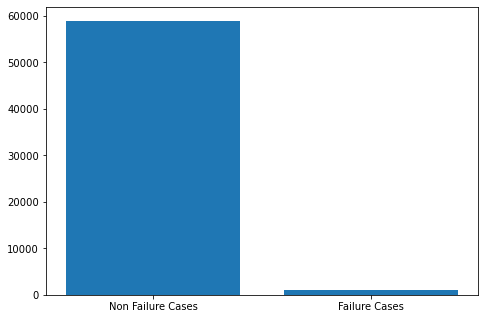

In [30]:
# Obtaining the total count of each class in the target variable
targets = data_df['target'].value_counts()


figure = plt.figure()
axes = figure.add_axes([0,0,1,1])
target_values = ['Non Failure Cases', 'Failure Cases']
counts = [targets[0], targets[1]]
print("No of Non Failure Cases",targets[0])
print("No of Failure Cases",targets[1])
axes.bar(target_values,counts)
plt.show()

### We see that the data is highly imbalanced with only 1000 data points in the minority class.

### PDF plots of each non temporal sensor

In [31]:
sensor_column_names = []
for column in data_df.columns:
    if column != 'id' and column != 'target':
        column_name = column.split("_")
        if column_name[1] != 'histogram':
            sensor_column_names.append(column)

In [32]:
for col in data_df.columns:
    data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

In [33]:
df_0 = data_df[data_df['target']==0]
df_1 = data_df[data_df['target']==1]

c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


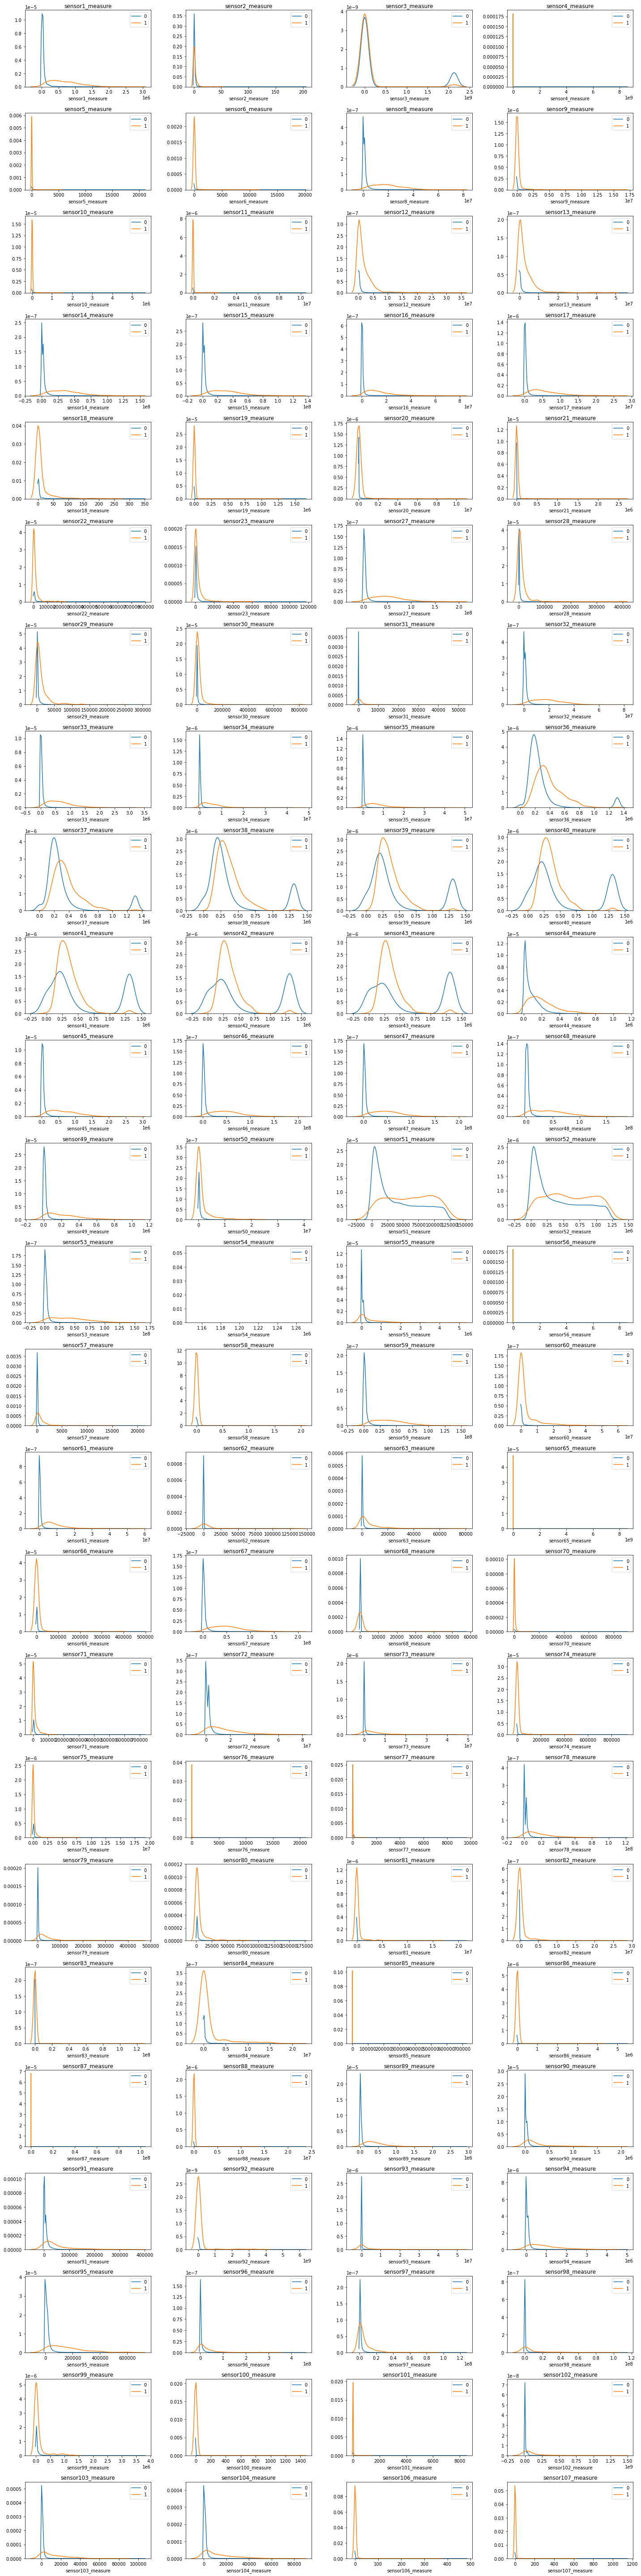

In [16]:
fig, axes = plt.subplots(25, 4, figsize=(20,80))
axes = axes.flatten()


for i,column in enumerate(sensor_column_names):
    sns.distplot(df_0[column], hist=False, ax=axes[i], label='0')
    sns.distplot(df_1[column], hist=False, ax=axes[i], label='1')
    axes[i].set_title(column)
    fig.tight_layout()


### Comments

- Most of the graphs are overlapping due to which it is difficult to segregate the data points by a particular sensor.
- There are few sensors whose graph is visually seperable such as Sensor 1, Sensor 8, Sensor 14-17, Sensor 27, Sensor 67 and several more.
- These seperable distributions add greater value to the final classification hence it would be necessary to look at their importance onces we apply the same on Models.

### Histogram plots

In [34]:
histogram_column_names = []
for column in data_df.columns:
    if column != 'id' and column != 'target':
        column_name = column.split("_")
        if column_name[1] == 'histogram':
            histogram_column_names.append(column)

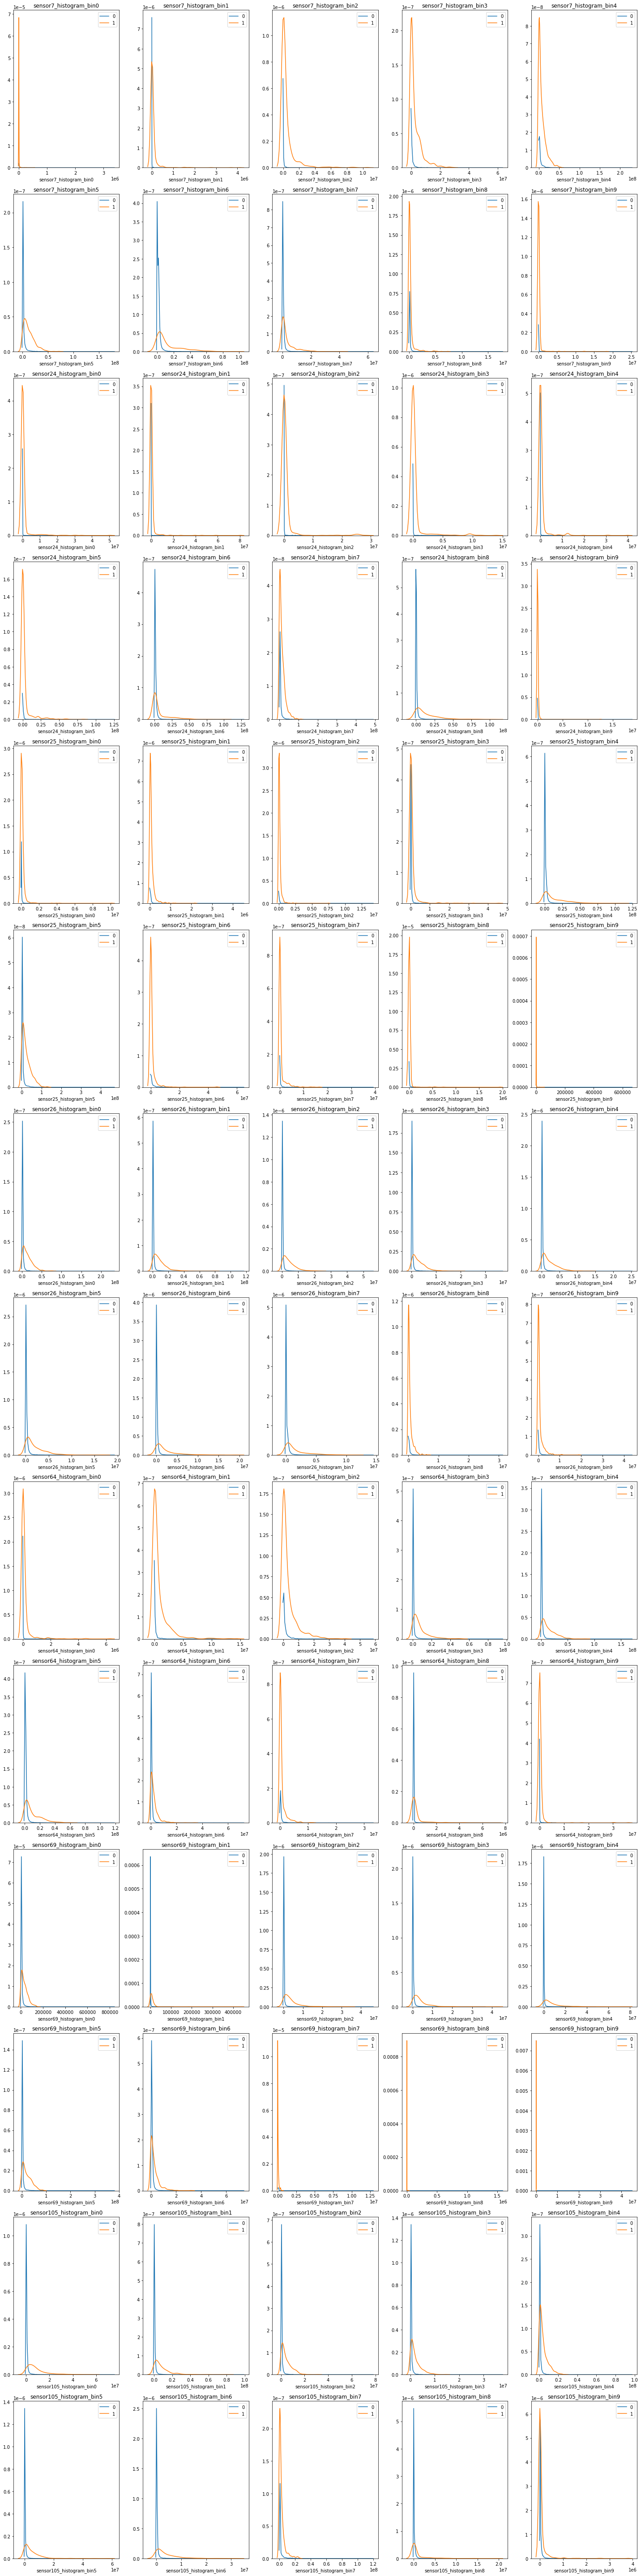

In [308]:
fig, axes = plt.subplots(14, 5, figsize=(20,80))
axes = axes.flatten()


for i,column in enumerate(histogram_column_names):
    sns.distplot(df_0[column], hist=False, ax=axes[i], label='0')
    sns.distplot(df_1[column], hist=False, ax=axes[i], label='1')
    axes[i].set_title(column)
    fig.tight_layout()


# Comments

- The histogram bins look similar to power law graphs.
- Most of the values are near zero suggesting the high number of 0 values in the bins.
- After analyzing all the graphs, it is difficult to visually seperate the values depending on their distributions of bins over time.

### Check Null values in each feature

In [35]:
# Checking null values in each column
null_values = data_df.isnull().sum(axis = 0)

In [36]:
value = []
names = []

for k, v in null_values.iteritems():
    if k!='target' and k!='id':
        names.append(k)
        value.append(v)

print(len(names), len(value))

170 170


In [312]:
fig = plt.figure(figsize=(200,100))
ax = fig.add_axes([0,0,1,1])
ax.bar(names[:85],value[:85])
plt.setp(ax.get_xticklabels(), fontsize=80, rotation='vertical')
plt.yticks(fontsize=80)
plt.show()

In [313]:
fig = plt.figure(figsize=(200,100))
ax = fig.add_axes([0,0,1,1])
ax.bar(names[85:170],value[85:170])
plt.setp(ax.get_xticklabels(), fontsize=80, rotation='vertical')
plt.yticks(fontsize=80)
plt.show()

# Comments

- There are few sensors who have most of the values are NULL namely Sensor 2, Sensor 38-43 and sensor 68
- These sensors columns will not contribute much to the final output and performing imputation will also spoil the nature of the data.

### Dropping columns with more than 50% Null values in the rows.

##### We can modify the dataframe in this situation before train, test split is because we are removing the entire column and not performing any modification to value or imputation.

In [37]:
null_values = null_values.sort_values(ascending=False)

##### Before Dropping Null values, checking their correlation with the target values for each column.

In [38]:
null_values_list = []
for column_name, value in null_values.items():
    if value > 30000:
        null_values_list.append(column_name)

print(null_values_list)

['sensor43_measure', 'sensor42_measure', 'sensor41_measure', 'sensor40_measure', 'sensor68_measure', 'sensor2_measure', 'sensor39_measure', 'sensor38_measure']


In [39]:
for column in null_values_list:
    print("Correlation between " + column + " and target is: " + str(data_df[column].corr(data_df['target'])))

Correlation between sensor43_measure and target is: -0.14302549793845026
Correlation between sensor42_measure and target is: -0.1314089144501884
Correlation between sensor41_measure and target is: -0.11065586976877181
Correlation between sensor40_measure and target is: -0.08666269235350962
Correlation between sensor68_measure and target is: 0.06622769406322888
Correlation between sensor2_measure and target is: 0.03189609336029865
Correlation between sensor39_measure and target is: -0.057736003010924256
Correlation between sensor38_measure and target is: -0.021159379309264103


### We see no correlation between the columns with null values >50% and the target column, thus we can drop the specified columns

In [40]:
# If the number of null values are greater than 50% of the data set it is better to drop them since they would not contribute anything.
print("Number of Columns before dropping null columns",data_df.shape[1])
for column_name, value in null_values.items():
    if value > 30000:
        data_df = data_df.drop([column_name], axis=1)
        
print("Number of Columns after dropping null columns",data_df.shape[1])

Number of Columns before dropping null columns 172
Number of Columns after dropping null columns 164


# Check for 0's in each feature

In [41]:
# Dropping columns with 95% zeros
zero_columns = []
for column in data_df.columns:
    if column != 'target' and column!='id':
        value = data_df[column].value_counts()
        if 0 in value:
            if value[0] >= (0.95*60000):
                zero_columns.append(column)
                print(column, '---> % of zeros',(value[0]*100/60000))

sensor7_histogram_bin0 ---> % of zeros 98.555
sensor7_histogram_bin1 ---> % of zeros 97.645
sensor19_measure ---> % of zeros 98.91666666666667
sensor21_measure ---> % of zeros 98.85
sensor24_histogram_bin0 ---> % of zeros 97.935
sensor24_histogram_bin1 ---> % of zeros 96.98666666666666
sensor24_histogram_bin2 ---> % of zeros 96.93666666666667
sensor24_histogram_bin3 ---> % of zeros 96.79666666666667
sensor24_histogram_bin4 ---> % of zeros 95.26333333333334
sensor24_histogram_bin9 ---> % of zeros 97.98166666666667
sensor25_histogram_bin9 ---> % of zeros 95.74166666666666
sensor64_histogram_bin0 ---> % of zeros 95.5
sensor106_measure ---> % of zeros 95.035


### Checking the correlation between the columns with >95% zeros and the target column

In [42]:
for column in zero_columns:
    print("Correlation between " + column + " and target is: " + str(data_df[column].corr(data_df['target'])))

Correlation between sensor7_histogram_bin0 and target is: 0.01236794096627984
Correlation between sensor7_histogram_bin1 and target is: 0.1914529489330061
Correlation between sensor19_measure and target is: 0.044105150644670195
Correlation between sensor21_measure and target is: 0.09313679837210051
Correlation between sensor24_histogram_bin0 and target is: 0.1570812112668717
Correlation between sensor24_histogram_bin1 and target is: 0.11190739521272185
Correlation between sensor24_histogram_bin2 and target is: 0.16556112873662518
Correlation between sensor24_histogram_bin3 and target is: 0.19103827667736897
Correlation between sensor24_histogram_bin4 and target is: 0.1799881213531043
Correlation between sensor24_histogram_bin9 and target is: 0.042447918598523156
Correlation between sensor25_histogram_bin9 and target is: 0.002531502034032262
Correlation between sensor64_histogram_bin0 and target is: 0.23227141693510897
Correlation between sensor106_measure and target is: 0.0183999672444

In [43]:
### We see no significant correlation between the columns with >95% zeros and the target columns, and hence we can drop the same.

In [44]:
value = []

for column in zero_columns:
    value.append(data_df[column].value_counts()[0])

In [318]:
fig = plt.figure(figsize=(200,100))
ax = fig.add_axes([0,0,1,1])
ax.bar(zero_columns,value)
plt.setp(ax.get_xticklabels(), fontsize=80, rotation='vertical')
plt.yticks(fontsize=80)
plt.show()

# Comments

- There are few sensors who have most of the values are Zero namely Sensor 7 bin 0-1, Sensor 19, Sensor 21, Sensor 24 bin 0-4, Sensor 24 bin9, Sensor 25 bin9, Sensor 64 bin0 and sensor 106 measure.
- These sensors have more than 95% of their values to zero thus providing no contribution to final classification.

### Dropping columns with >95% number of rows of zero

##### We can modify the dataframe in this situation before train, test split is because we are removing the entire column and not performing any modification to value or imputation.

In [45]:
print("Number of columns before dropping Zero columns:", data_df.shape[1])
data_df = data_df.drop(zero_columns, axis=1)
print("Number of columns after dropping Zero columns:", data_df.shape[1])

Number of columns before dropping Zero columns: 164
Number of columns after dropping Zero columns: 151


### Check for distinction between the two classes using quantile and box plots

In [46]:
df_0 = data_df[data_df['target']==0]
df_1 = data_df[data_df['target']==1]

In [47]:
# Checking the percentile of 0 and 1 of each column to see which features provide better seperation.
# comparing if 90th percentile of 0 < 10th percentile of 1 and also 10th percentile of 1 > 90th percentile of 0
# Choosing Columns between 10 and 90th percentile with significant difference in the two class distribution

quantiles_0 = df_0.quantile([0.1, 0.9], axis=0)
quantiles_1 = df_1.quantile([0.1, 0.9], axis=0)

important_features = []
for col in quantiles_0.columns:
    if col != 'id' and col != 'target':
        col_name = col.split("_")
        if (quantiles_0[col].iloc[0] > quantiles_1[col].iloc[1]) or (quantiles_1[col].iloc[0] > quantiles_0[col].iloc[1]) and (col_name[1] != 'histogram'):
            important_features.append(col)

# print(important_features[:5], len(important_features))

#### These are the features which may add importance in the decision making at the end since the 10th and 90th percentile of each of these features are seperable and hence useful in decision making. The sensors that are part of this are as follows
```
 sensor1_measure
 sensor8_measure
 sensor14_measure
 sensor15_measure
 sensor16_measure
 sensor17_measure
 sensor27_measure
 sensor32_measure
 sensor33_measure
 sensor34_measure
 sensor35_measure
 sensor45_measure
 sensor46_measure
 sensor47_measure
 sensor59_measure
 sensor61_measure
 sensor67_measure
 sensor89_measure
 ````

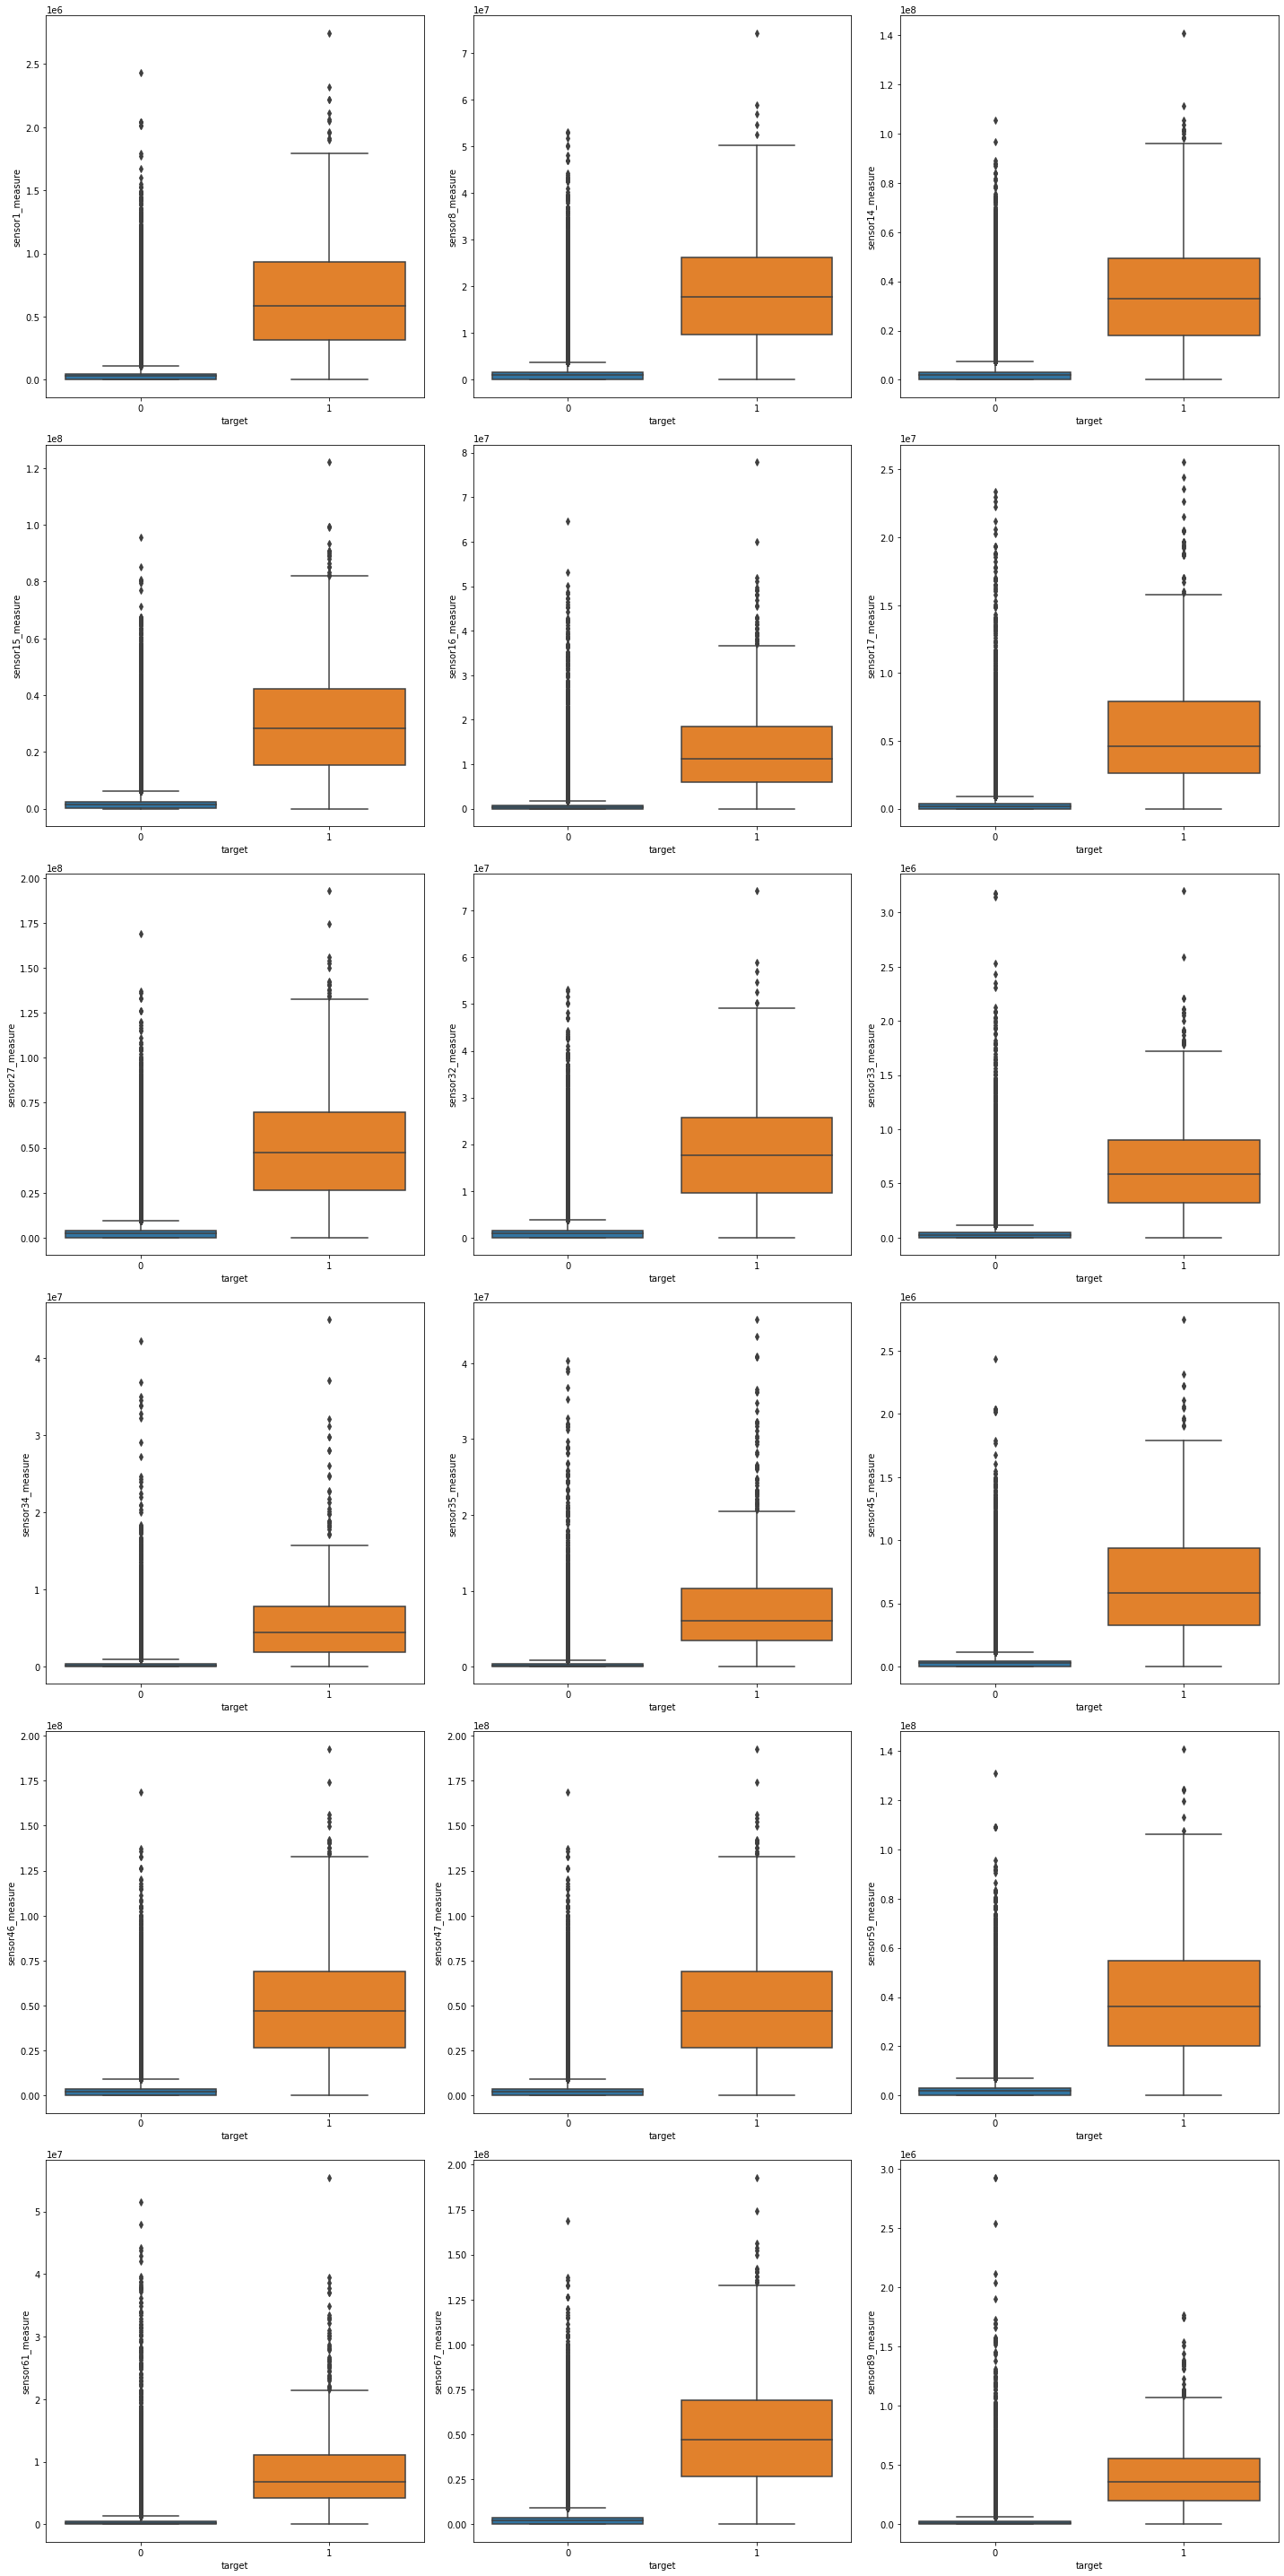

In [22]:
fig, axes = plt.subplots(6, 3, figsize=(20,40))
axes = axes.flatten()

for i, column in enumerate(important_features):
    ax = sns.boxplot(x="target", y=column, data=data_df,  ax=axes[i])

fig.tight_layout()

# Comments

- The above box plots are for the features whose distribution is highly seperable where the 10th percentile of one class is greater than 90th percentile of the other class.
- Since most of the data can be classified visually from these sensors, it is important to note that these features might contribute more to the final classification and also it would be important to note if these features are correlated.

# TSNE plot for all the features

In [48]:
for col in data_df_copy.columns:
    data_df_copy[col] = pd.to_numeric(data_df_copy[col], errors='coerce')

In [49]:
# Using the copy of the dataset which was saved in the beginning since the other variable of dataset was modified.
data_df_copy = data_df_copy.fillna(data_df_copy.median())

y_true = data_df_copy['target']
data_df_copy = data_df_copy.drop(['target'],axis=1)
data_df_copy = data_df_copy.drop(['id'],axis=1)

TSNE with various perplexities and a standard 1000 iterations


c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x720 with 0 Axes>

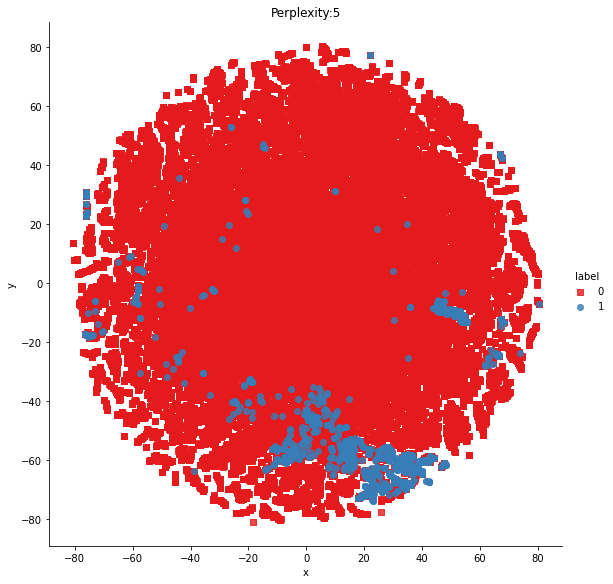

c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x720 with 0 Axes>

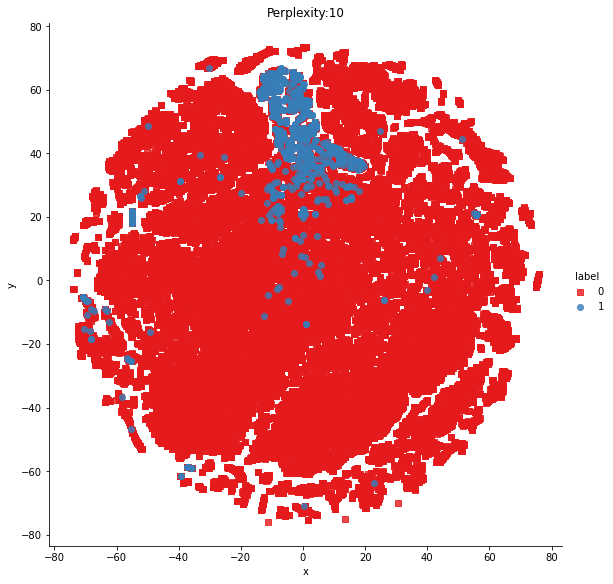

c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x720 with 0 Axes>

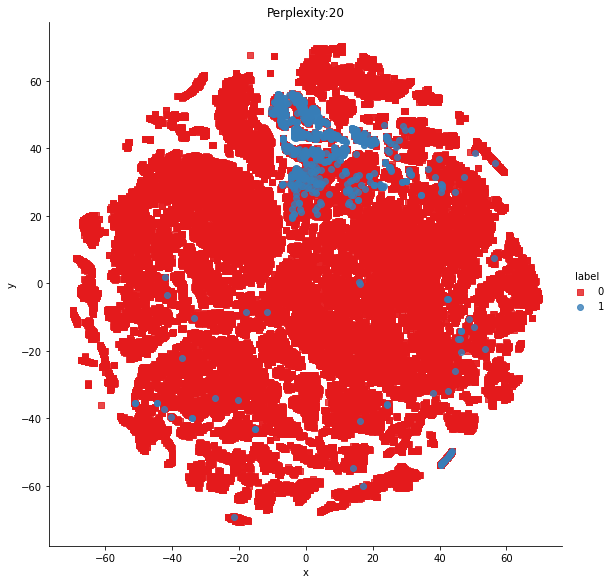

c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x720 with 0 Axes>

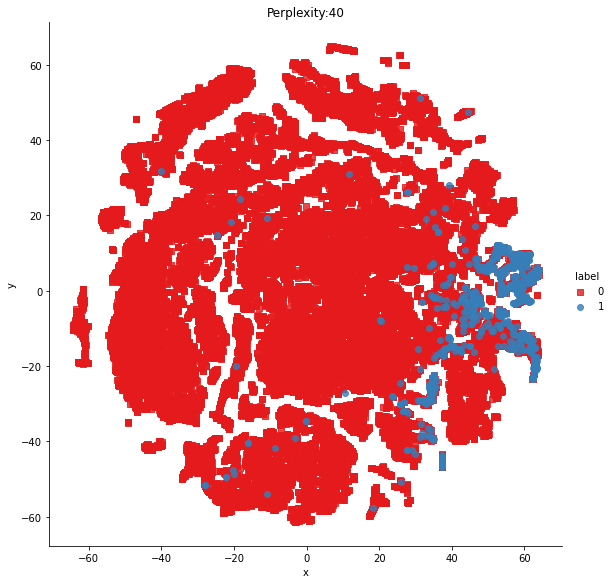

In [376]:
# Computing TSNE for each perplexity and displaying graph using seaborn plots
perplexity = [5, 10, 20, 40]
print("TSNE with various perplexities and a standard 1000 iterations")

for ppx in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=ppx, n_iter=1000)
    tsne_data = tsne.fit_transform(data_df_copy)
    plt.figure(figsize=(15,10))
    df = pd.DataFrame({'x':tsne_data[:,0], 'y':tsne_data[:,1] ,'label':y_true})
    sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8, palette="Set1", markers=['s','o'])
    plt.title("Perplexity:{}".format(ppx))
    plt.show()


## Comments

- From each of the TSNE plots we see that the data gets better grouped but the data is still overlapping on a 2D surface and thus converting the higher dimension data to a 2D data does not help in seperation.

# TSNE plot for important non time based sensors and easily seperable features

In [50]:
important_df = data_df_copy[[ 'sensor1_measure','sensor8_measure', 'sensor14_measure', 'sensor15_measure', 'sensor16_measure', 'sensor17_measure', 'sensor27_measure', 'sensor32_measure', 'sensor33_measure', 'sensor34_measure', 'sensor35_measure', 'sensor45_measure', 'sensor46_measure', 'sensor47_measure', 'sensor59_measure', 'sensor61_measure', 'sensor67_measure', 'sensor89_measure']]

c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x720 with 0 Axes>

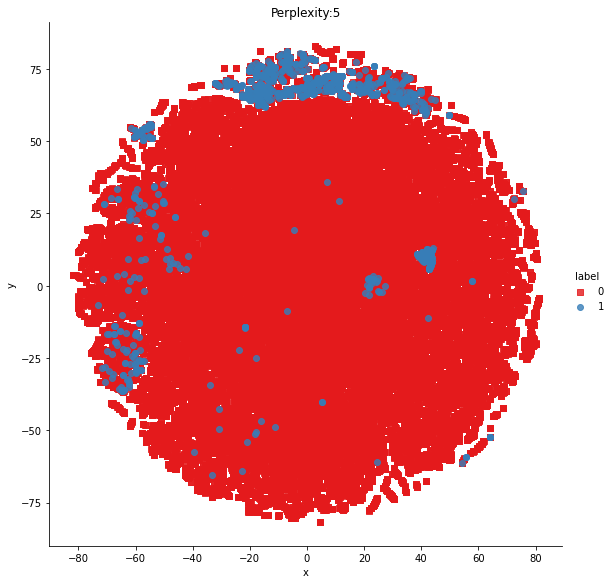

c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x720 with 0 Axes>

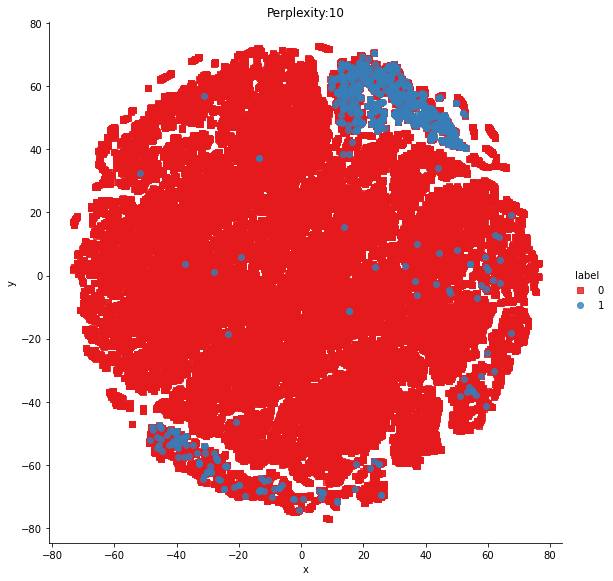

c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x720 with 0 Axes>

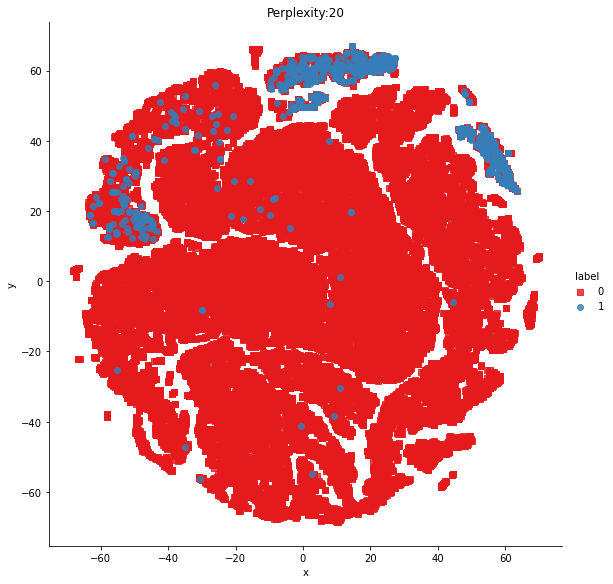

c:\users\manish dalvi\appdata\local\programs\python\python37\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x720 with 0 Axes>

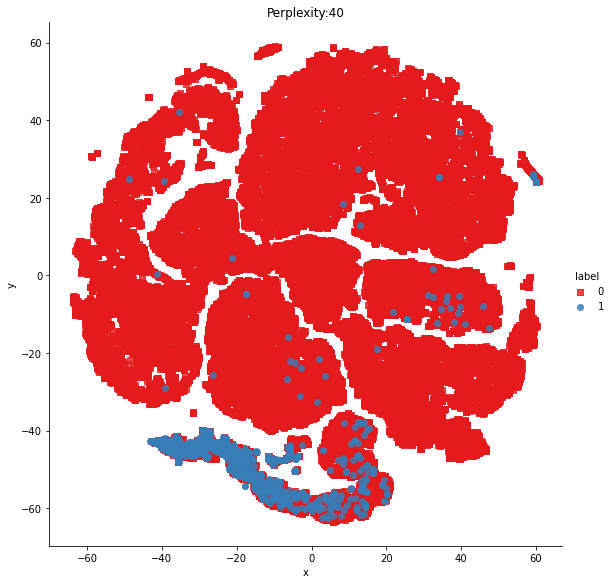

In [378]:
# Computing TSNE for each perplexity and displaying graph using seaborn plots
perplexity = [5, 10, 20, 40]

for ppx in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=ppx, n_iter=1000)
    tsne_data = tsne.fit_transform(important_df)
    plt.figure(figsize=(15,10))
    df = pd.DataFrame({'x':tsne_data[:,0], 'y':tsne_data[:,1] ,'label':y_true})
    sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8, palette="Set1", markers=['s','o'])
    plt.title("Perplexity:{}".format(ppx))
    plt.show()


## Comments

- Even with features that have their box plots mostly seperable, we still see the overlap between the two classes and hence no defining boundary in 2D for their classification.

## Correlation between easily seperable features

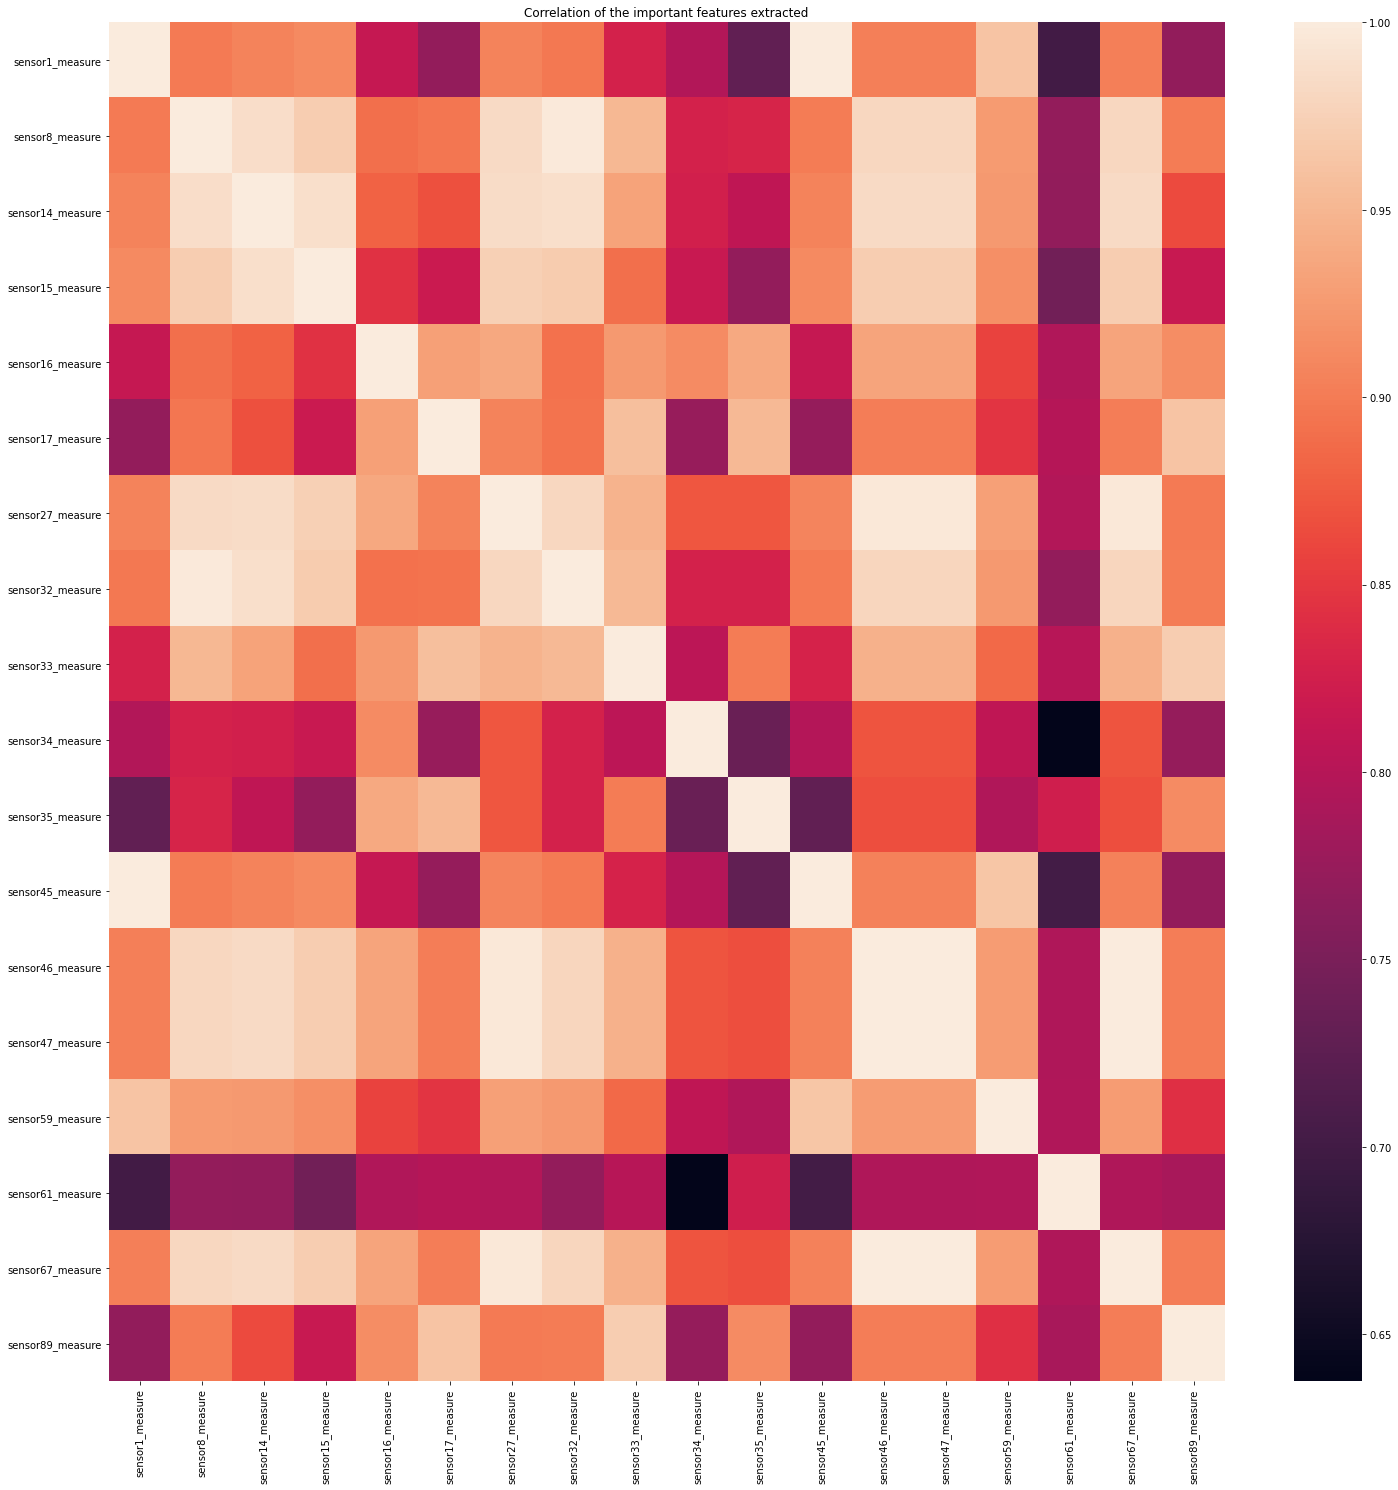

In [51]:
# Calculating Correlation and plotting the Heat map of the correlated data
important_correlation = important_df.corr()
plt.figure(figsize=(25,25))
sns.heatmap(important_correlation)
plt.title("Correlation of the important features extracted")
plt.show()

### We see high correlation between few sensors with a value almost above 0.99 such as

- Sensor 1 and Sensor 45
- Sensor 8 and Sensor 32
- Sensor 27 and Sensor 46
- Sensor 46 and Sensor 47
- Sensor 47 and Sensor 67

### We can drop those features that are highly correlated and keep only one among them.

In [52]:
for i, column_1 in enumerate(important_correlation.columns):
    for j in range(i, len(important_correlation.columns)):
        column_2 = important_correlation.columns[j]
        if column_1 != column_2:
            if important_correlation[column_1][column_2] > 0.99:
                print(column_1,"--", column_2, "Correlation Value: ",important_correlation[column_1][column_2])

sensor1_measure -- sensor45_measure Correlation Value:  0.9987741087714981
sensor8_measure -- sensor32_measure Correlation Value:  0.9977448921173756
sensor27_measure -- sensor46_measure Correlation Value:  0.9962581925040437
sensor27_measure -- sensor47_measure Correlation Value:  0.9962581925084124
sensor27_measure -- sensor67_measure Correlation Value:  0.996258192484215
sensor46_measure -- sensor47_measure Correlation Value:  0.9999999999896727
sensor46_measure -- sensor67_measure Correlation Value:  0.9999999999909073
sensor47_measure -- sensor67_measure Correlation Value:  0.9999999999987332


# Heatmap of the histogram data

In [53]:
histogram_columns = dict()

for column in data_df_copy.columns:
    value = column.split("_")
    if value[1] == 'histogram':
        if value[0] not in histogram_columns:
            histogram_columns[value[0]] = []
        histogram_columns[value[0]].append(column)
print(histogram_columns)

{'sensor7': ['sensor7_histogram_bin0', 'sensor7_histogram_bin1', 'sensor7_histogram_bin2', 'sensor7_histogram_bin3', 'sensor7_histogram_bin4', 'sensor7_histogram_bin5', 'sensor7_histogram_bin6', 'sensor7_histogram_bin7', 'sensor7_histogram_bin8', 'sensor7_histogram_bin9'], 'sensor24': ['sensor24_histogram_bin0', 'sensor24_histogram_bin1', 'sensor24_histogram_bin2', 'sensor24_histogram_bin3', 'sensor24_histogram_bin4', 'sensor24_histogram_bin5', 'sensor24_histogram_bin6', 'sensor24_histogram_bin7', 'sensor24_histogram_bin8', 'sensor24_histogram_bin9'], 'sensor25': ['sensor25_histogram_bin0', 'sensor25_histogram_bin1', 'sensor25_histogram_bin2', 'sensor25_histogram_bin3', 'sensor25_histogram_bin4', 'sensor25_histogram_bin5', 'sensor25_histogram_bin6', 'sensor25_histogram_bin7', 'sensor25_histogram_bin8', 'sensor25_histogram_bin9'], 'sensor26': ['sensor26_histogram_bin0', 'sensor26_histogram_bin1', 'sensor26_histogram_bin2', 'sensor26_histogram_bin3', 'sensor26_histogram_bin4', 'sensor26_

In [54]:
bins = []
for column, histograms in histogram_columns.items():
    bins.extend(histograms)
print(len(bins))

70


In [55]:
histogram_data = data_df_copy[bins]
print(histogram_data.shape)

(60000, 70)


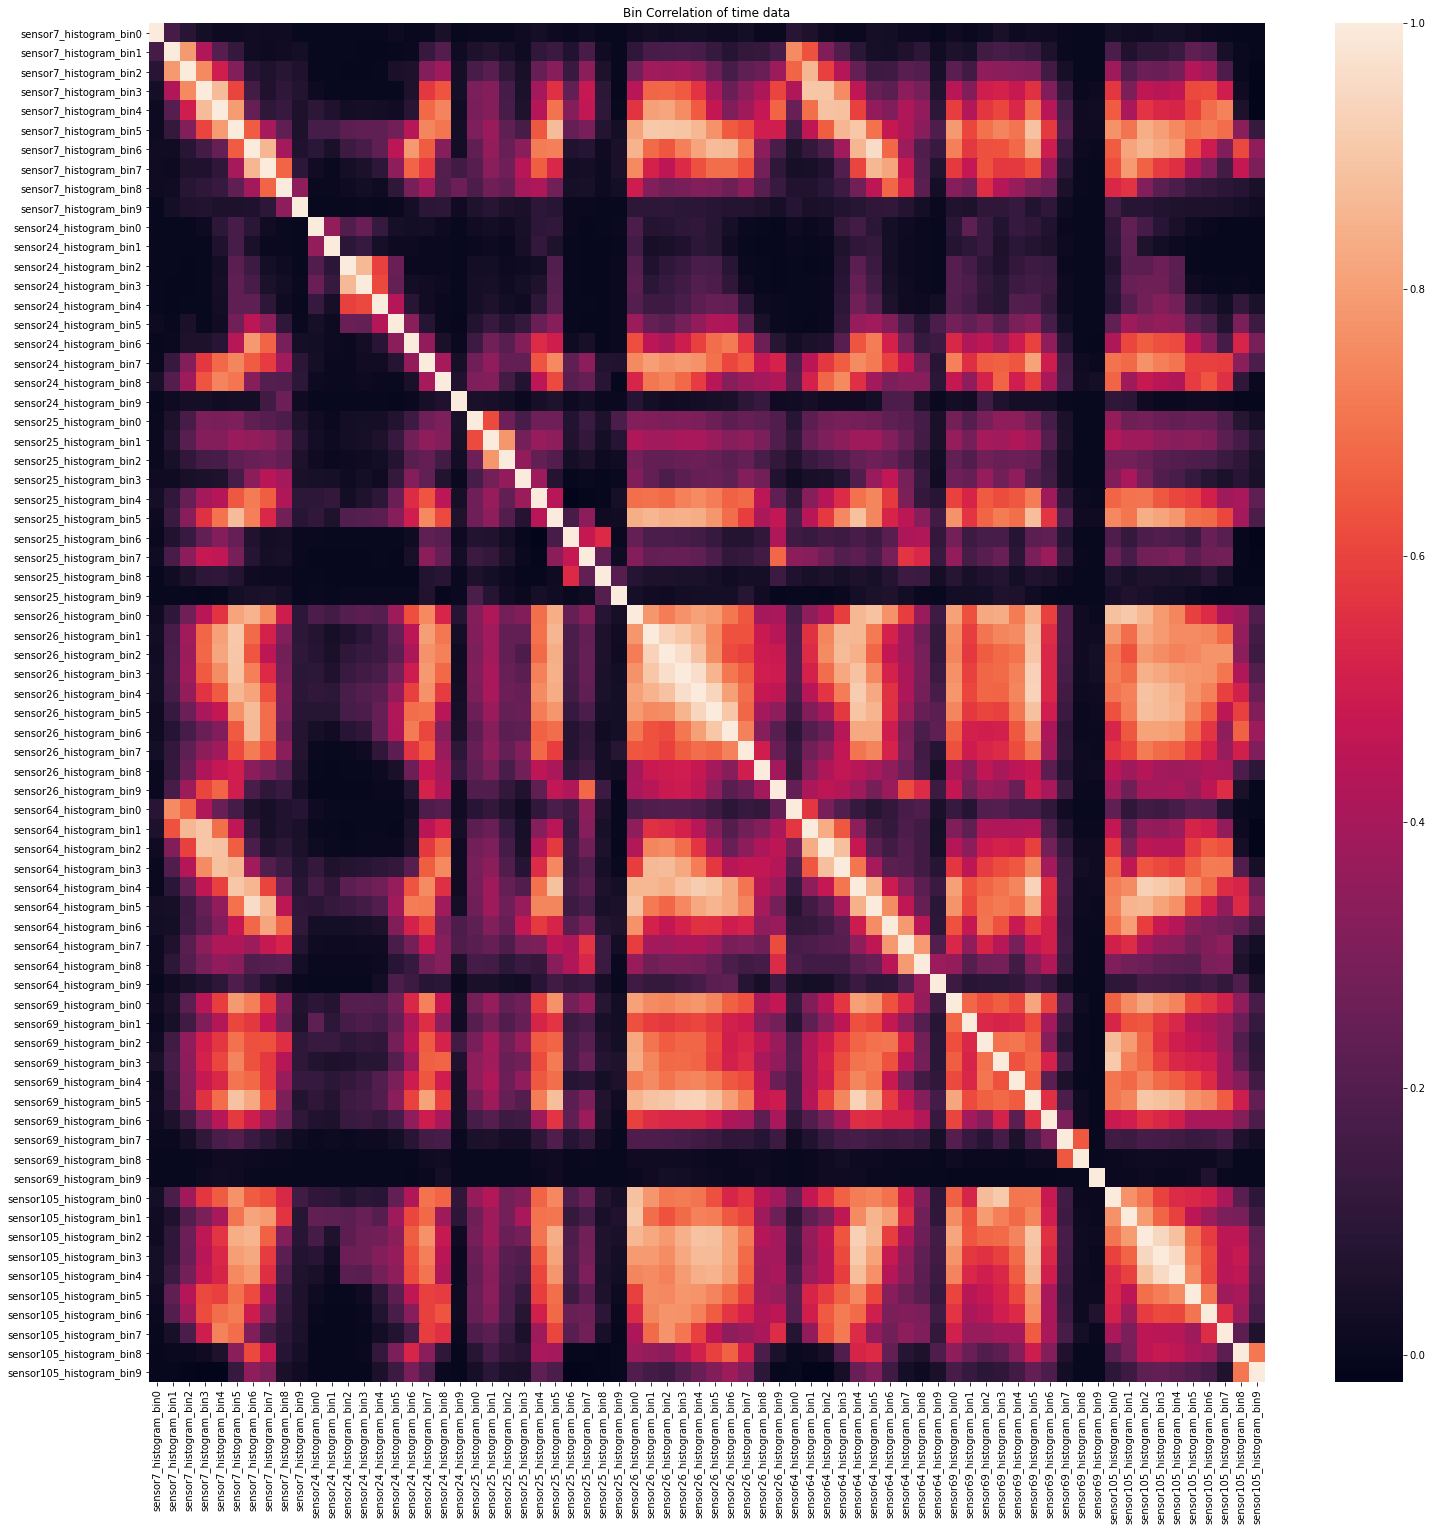

In [56]:
# Calculating Correlation and plotting the Heat map of the correlated data
bin_correlation = histogram_data.corr()
plt.figure(figsize=(25,25))
sns.heatmap(bin_correlation)
plt.title("Bin Correlation of time data")
plt.show()

### Among the various histogram bins,

- We see a correlation between the same sensor bins as they are continuous in times
- We also see high correlation between bins of different sensors such as Sensor 7 bin 6 and Sensor 64 bin 5 with correlation value above 0.95

# Columns with high correlation data with some other column are as follows

In [57]:
for i, column_1 in enumerate(bin_correlation.columns):
    for j in range(i, len(bin_correlation.columns)):
        column_2 = bin_correlation.columns[j]
        if column_1 != column_2:
            if bin_correlation[column_1][column_2] > 0.95:
                print(column_1,"--", column_2, "Correlation Value: ",bin_correlation[column_1][column_2])

sensor7_histogram_bin6 -- sensor64_histogram_bin5 Correlation Value:  0.9567868937028872
sensor26_histogram_bin2 -- sensor26_histogram_bin3 Correlation Value:  0.9649715653249044
sensor26_histogram_bin3 -- sensor26_histogram_bin4 Correlation Value:  0.9669830664646321
sensor105_histogram_bin3 -- sensor105_histogram_bin4 Correlation Value:  0.9558991915181737


#### From observing the values, most bins which are next in time are the ones with high correlation since the sensor values are continution of the previous bin values like "sensor7_histogram_bin6 -- sensor64_histogram_bin5".

#### The other 3 are correlation between subsequent bins of the same sensor due their time based relations

In [58]:
for i, column_1 in enumerate(bin_correlation.columns):
    for j in range(i, len(bin_correlation.columns)):
        column_1 = bin_correlation.columns[i]
        column_2 = bin_correlation.columns[j]
        if column_1 != column_2:
            sensor1 = column_1.split("_")[0]
            sensor2 = column_2.split("_")[0]
            if sensor1 !=  sensor2:
                if bin_correlation[column_1][column_2] > 0.95:
                    print(column_1,"--", column_2, "Correlation Value: ",bin_correlation[column_1][column_2])

sensor7_histogram_bin6 -- sensor64_histogram_bin5 Correlation Value:  0.9567868937028872


## -------------------------------------------------------------------------------------------------------------------------------------

# Data Preprocessing

In [59]:
y_true = data_df['target']

data_df = data_df.drop(['target'],axis=1)
data_df = data_df.drop(['id'],axis=1)

In [60]:
data_df.shape

(60000, 149)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data_df, y_true, stratify=y_true, test_size=0.2)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [62]:
print(X_train.shape, X_cv.shape, X_test.shape)

(38400, 149) (9600, 149) (12000, 149)


### From the above correlation values we see many sensors are correlated. We will remove the ones which are above 0.99 which means it is almost same as the other sensor and keep only among them.

- sensor1_measure : sensor45_measure Correlation Value:  0.9987741087714981
- sensor8_measure : sensor32_measure Correlation Value:  0.9977448921173756
- sensor27_measure : sensor46_measure Correlation Value:  0.9962581925040437
- sensor27_measure : sensor47_measure Correlation Value:  0.9962581925084124
- sensor27_measure : sensor67_measure Correlation Value:  0.996258192484215
- sensor46_measure : sensor47_measure Correlation Value:  0.9999999999896727
- sensor46_measure : sensor67_measure Correlation Value:  0.9999999999909073
- sensor47_measure : sensor67_measure Correlation Value:  0.9999999999987332

In [63]:
high_correlated_columns = ['sensor45_measure', 'sensor32_measure', 'sensor46_measure', 'sensor47_measure', 'sensor67_measure']
for column in high_correlated_columns:
    if column in X_train.columns:
        X_train = X_train.drop([column],axis=1)
        X_cv = X_cv.drop([column],axis=1)
        X_test = X_test.drop([column],axis=1)

### As discussed above, from the histogram bins, if there is a correlation between two different sensor bins then we should delete it. If there is correlation between the two bins of same sensor then it is due to subsequent time data.

- sensor7_histogram_bin6 : sensor64_histogram_bin5 Correlation Value:  0.9567868937028872

In [64]:
X_train = X_train.drop(['sensor64_histogram_bin5'],axis=1)
X_cv = X_cv.drop(['sensor64_histogram_bin5'],axis=1)
X_test = X_test.drop(['sensor64_histogram_bin5'],axis=1)

### After removing all the unwanted columns, we are left with 143 columns.

In [65]:
print(X_train.shape, X_cv.shape, X_test.shape)

(38400, 143) (9600, 143) (12000, 143)


### We have already dropped columns with large amount of zeros and NaN. Now we can impute the remaining NaN values with the median imputation. 
### Median imputation is performed since median is less error prone in this scenaria where there is large flucation of sensor readings. Mean would provide a volatile value since either the values are zero or very large.

In [66]:
median_values = X_train.median()

X_train_median = X_train.fillna(median_values)
X_cv_median = X_cv.fillna(median_values)
X_test_median = X_test.fillna(median_values)

print(X_train_median.shape, X_cv_median.shape, X_test_median.shape)

(38400, 143) (9600, 143) (12000, 143)


In [67]:
dump(median_values, 'median_values.joblib') 


['median_values.joblib']

In [89]:
with open('median_values.pkl', 'wb') as file:
    pickle.dump(median_values, file)

In [68]:
column_names = X_train.columns

In [69]:
X_train_median

sensor1_measure  sensor3_measure  sensor4_measure  sensor5_measure  \
40583             2256     3.000000e+01             20.0              0.0   
28732             1384     3.400000e+01             32.0              0.0   
15503            40854     1.520000e+02             80.0              0.0   
34808               14     1.400000e+01              6.0              0.0   
40025            28800     2.520000e+02            244.0              0.0   
...                ...              ...              ...              ...   
42629             2236     2.400000e+01            126.0              0.0   
49812           229694     1.500000e+02            126.0              0.0   
45178           101630     4.280000e+02            412.0              0.0   
16101            40226     2.130706e+09            600.0              0.0   
53966             1704     2.800000e+01             18.0              0.0   

       sensor6_measure  sensor7_histogram_bin2  sensor7_histogram_bin3  \
40583              0.0                     0.0                     0.0   
28732              0.0                     0.0                     0.0   
15503              0.0                     0.0                     0.0   
34808              0.0                     0.0                     0.0   
40025              0.0                     0.0                     0.0   
...                ...                     ...                     ...   
42629              0.0                     0.0                 38136.0   
49812              0.0                     0.0                525914.0   
45178              0.0                     0.0                     0.0   
16101              0.0                     0.0                     0.0   
53966              0.0                     0.0                     0.0   

       sensor7_histogram_bin4  sensor7_histogram_bin5  sensor7_histogram_bin6  \
40583                  3746.0                178106.0                931122.0   
28732                   196.0                 32770.0                 45914.0   
15503                  7710.0                561240.0               1888174.0   
34808                    70.0                  3730.0                  2494.0   
40025                  1876.0                209710.0               1291356.0   
...                       ...                     ...                     ...   
42629                120410.0                  9660.0                  1262.0   
49812               9314812.0              23660526.0              21448308.0   
45178                 28276.0               2725512.0               3747300.0   
16101                   508.0                191428.0               2493750.0   
53966                 20398.0                 75480.0                  4236.0   

       ...  sensor105_histogram_bin1  sensor105_histogram_bin2  \
40583  ...                  348980.0                  234915.0   
28732  ...                    9196.0                    4110.0   
15503  ...                  431328.0                  373538.0   
34808  ...                    1740.0                     106.0   
40025  ...                  343080.0                  309968.0   
...    ...                       ...                       ...   
42629  ...                   21288.0                    4676.0   
49812  ...                10097812.0                 6529190.0   
45178  ...                 1305642.0                  721882.0   
16101  ...                  597714.0                  540596.0   
53966  ...                    8124.0                    3242.0   

       sensor105_histogram_bin3  sensor105_histogram_bin4  \
40583                  112901.0                  221924.0   
28732                    1048.0                    9880.0   
15503                  178972.0                  347670.0   
34808                      56.0                      68.0   
40025                  195206.0                  402762.0   
...                         ...                       ...   


### KNN based nearest neighbour imputation so as to provide more accurate imputation over simple imputations of median, mean, most frequent.

In [237]:
knn_imputer = KNNImputer(weights="distance")

X_train_knn_imputation = knn_imputer.fit_transform(X_train)
X_cv_knn_imputation = knn_imputer.transform(X_cv)
X_test_knn_imputation = knn_imputer.transform(X_test)

print(X_train_knn_imputation.shape, X_cv_knn_imputation.shape, X_test_knn_imputation.shape)

(38400, 143) (9600, 143) (12000, 143)


In [238]:
print(X_train_knn_imputation.shape, X_cv_knn_imputation.shape, X_test_knn_imputation.shape)

(38400, 143) (9600, 143) (12000, 143)


In [239]:
X_train_knn_imputation = pd.DataFrame(X_train_knn_imputation)
X_cv_knn_imputation = pd.DataFrame(X_cv_knn_imputation)
X_test_knn_imputation = pd.DataFrame(X_test_knn_imputation)

X_train_knn_imputation.columns = column_names
X_cv_knn_imputation.columns = column_names
X_test_knn_imputation.columns = column_names

## -------------------------------------------------------------------------------------------------------------------------------------

# Feature Engineering

### Addition of 2 columns using Truncated SVD as part of feature engineering for median and knn imputated values.

In [71]:
T_SVD = TruncatedSVD(n_components=4, n_iter=20)

X_train_median_tSVD = T_SVD.fit_transform(X_train_median)
X_cv_median_tSVD = T_SVD.transform(X_cv_median)
X_test_median_tSVD = T_SVD.fit_transform(X_test_median)

print(X_train_median_tSVD.shape, X_cv_median_tSVD.shape, X_test_median_tSVD.shape)

(38400, 4) (9600, 4) (12000, 4)


In [72]:
dump(T_SVD, 'truncated_SVD.joblib') 

['truncated_SVD.joblib']

In [90]:
with open('truncated_SVD.pkl', 'wb') as file:
    pickle.dump(T_SVD, file)

In [73]:
for i in range(4):
    X_train_median["SVD_"+str(i)] = X_train_median_tSVD[:,i]
    X_cv_median["SVD_"+str(i)] = X_cv_median_tSVD[:,i]
    X_test_median["SVD_"+str(i)] = X_test_median_tSVD[:,i]

print(X_train_median.shape, X_cv_median.shape, X_test_median.shape)

(38400, 147) (9600, 147) (12000, 147)


In [242]:
T_SVD = TruncatedSVD(n_components=4, n_iter=20)

X_train_knn_imputation_tSVD = T_SVD.fit_transform(X_train_knn_imputation)
X_cv_knn_imputation_tSVD = T_SVD.transform(X_cv_knn_imputation)
X_test_knn_imputation_tSVD = T_SVD.fit_transform(X_test_knn_imputation)

print(X_train_knn_imputation_tSVD.shape, X_cv_knn_imputation_tSVD.shape, X_test_knn_imputation_tSVD.shape)

(38400, 4) (9600, 4) (12000, 4)


In [243]:
for i in range(4):
    X_train_knn_imputation["SVD_"+str(i)] = X_train_knn_imputation_tSVD[:,i]
    X_cv_knn_imputation["SVD_"+str(i)] = X_cv_knn_imputation_tSVD[:,i]
    X_test_knn_imputation["SVD_"+str(i)] = X_test_knn_imputation_tSVD[:,i]

print(X_train_knn_imputation.shape, X_cv_knn_imputation.shape, X_test_knn_imputation.shape)

(38400, 147) (9600, 147) (12000, 147)


### Add bin average as a seperate column

In [74]:
column_names = dict()

for column in X_train_median.columns:
    value = column.split("_")
    if value[1] == 'histogram':
        if value[0] not in column_names:
            column_names[value[0]] = []
        column_names[value[0]].append(column)
        
print(column_names)

{'sensor7': ['sensor7_histogram_bin2', 'sensor7_histogram_bin3', 'sensor7_histogram_bin4', 'sensor7_histogram_bin5', 'sensor7_histogram_bin6', 'sensor7_histogram_bin7', 'sensor7_histogram_bin8', 'sensor7_histogram_bin9'], 'sensor24': ['sensor24_histogram_bin5', 'sensor24_histogram_bin6', 'sensor24_histogram_bin7', 'sensor24_histogram_bin8'], 'sensor25': ['sensor25_histogram_bin0', 'sensor25_histogram_bin1', 'sensor25_histogram_bin2', 'sensor25_histogram_bin3', 'sensor25_histogram_bin4', 'sensor25_histogram_bin5', 'sensor25_histogram_bin6', 'sensor25_histogram_bin7', 'sensor25_histogram_bin8'], 'sensor26': ['sensor26_histogram_bin0', 'sensor26_histogram_bin1', 'sensor26_histogram_bin2', 'sensor26_histogram_bin3', 'sensor26_histogram_bin4', 'sensor26_histogram_bin5', 'sensor26_histogram_bin6', 'sensor26_histogram_bin7', 'sensor26_histogram_bin8', 'sensor26_histogram_bin9'], 'sensor64': ['sensor64_histogram_bin1', 'sensor64_histogram_bin2', 'sensor64_histogram_bin3', 'sensor64_histogram_b

In [75]:
def add_average_bin_feature(df, column_names):
    for sensor in column_names.keys():
        bins = column_names[sensor]
        temp_df = df[bins]
        df[sensor+'_bin_average'] = temp_df.mean(axis=1)
    return df

In [76]:
X_train_median = add_average_bin_feature(X_train_median, column_names)
X_cv_median = add_average_bin_feature(X_cv_median, column_names)
X_test_median = add_average_bin_feature(X_test_median, column_names)

In [ ]:

X_train_knn_imputation = add_average_bin_feature(X_train_knn_imputation, column_names)
X_cv_knn_imputation = add_average_bin_feature(X_cv_knn_imputation, column_names)
X_test_knn_imputation = add_average_bin_feature(X_test_knn_imputation, column_names)

In [77]:
X_train_median.head()

sensor1_measure  sensor3_measure  sensor4_measure  sensor5_measure  \
40583             2256             30.0             20.0              0.0   
28732             1384             34.0             32.0              0.0   
15503            40854            152.0             80.0              0.0   
34808               14             14.0              6.0              0.0   
40025            28800            252.0            244.0              0.0   

       sensor6_measure  sensor7_histogram_bin2  sensor7_histogram_bin3  \
40583              0.0                     0.0                     0.0   
28732              0.0                     0.0                     0.0   
15503              0.0                     0.0                     0.0   
34808              0.0                     0.0                     0.0   
40025              0.0                     0.0                     0.0   

       sensor7_histogram_bin4  sensor7_histogram_bin5  sensor7_histogram_bin6  \
40583                  3746.0                178106.0                931122.0   
28732                   196.0                 32770.0                 45914.0   
15503                  7710.0                561240.0               1888174.0   
34808                    70.0                  3730.0                  2494.0   
40025                  1876.0                209710.0               1291356.0   

       ...         SVD_1        SVD_2         SVD_3  sensor7_bin_average  \
40583  ...  9.110917e+04   435.228859  1.638060e+06            154320.50   
28732  ...  2.193059e+04   208.404141  4.528442e+05              9980.50   
15503  ...  1.216150e+06  7863.711823  3.995469e+07            334663.50   
34808  ...  4.660034e+03   145.002147  2.520289e+04               786.75   
40025  ...  4.249526e+05   869.460531  3.030346e+06            240138.00   

       sensor24_bin_average  sensor25_bin_average  sensor26_bin_average  \
40583              153741.0          69177.111111              171349.1   
28732               19961.0           8871.555556                7984.4   
15503              669327.0         297478.666667              267730.8   
34808                1573.5            699.333333                 629.4   
40025              480276.0         213456.000000              192110.4   

       sensor64_bin_average  sensor69_bin_average  sensor105_bin_average  
40583              83406.75              171308.8               151031.1  
28732               8942.25                7984.4                 7984.4  
15503             166458.50              267730.8               267730.8  
34808                724.00                 629.4                  629.4  
40025             106129.25              192110.4               192110.4  

[5 rows x 154 columns]

In [248]:
X_train_knn_imputation.head()

sensor1_measure  sensor3_measure  sensor4_measure  sensor5_measure  \
0          39392.0     5.720000e+02            526.0              0.0   
1             84.0     0.000000e+00              0.0              0.0   
2            154.0     3.400000e+01             32.0              0.0   
3          39524.0     7.200000e+01             64.0              0.0   
4          39944.0     2.130706e+09            242.0              0.0   

   sensor6_measure  sensor7_histogram_bin2  sensor7_histogram_bin3  \
0              0.0                     0.0                     0.0   
1              0.0                     0.0                     0.0   
2              0.0                   226.0                 17450.0   
3              0.0                     0.0                   366.0   
4              0.0                     0.0                     0.0   

   sensor7_histogram_bin4  sensor7_histogram_bin5  sensor7_histogram_bin6  \
0                  8344.0               1377998.0               1805644.0   
1                  1820.0                 13922.0                  4246.0   
2                  5540.0                  2686.0                  1416.0   
3                175612.0               1088804.0                948014.0   
4                  1368.0                539542.0               1157978.0   

   ...         SVD_1        SVD_2         SVD_3  sensor7_bin_average  \
0  ...  1.034873e+06  1404.944205  3.755328e+06            434186.00   
1  ...  1.025356e+04   110.429067  3.816770e+04              2511.50   
2  ...  8.266482e+03   139.174866  3.158457e+04              3414.75   
3  ...  7.900222e+05  1015.265469  3.239279e+06            291842.00   
4  ... -1.734591e+07  -384.594626 -1.107521e+07            293266.50   

   sensor24_bin_average  sensor25_bin_average  sensor26_bin_average  \
0              868372.0         385943.111111              347348.8   
1                5023.0           2232.444444                2009.2   
2                6829.5           3035.333333                2731.8   
3              583684.0         259415.111111              233473.6   
4              586533.0         260681.333333              234613.2   

   sensor64_bin_average  sensor69_bin_average  sensor105_bin_average  
0             300847.50              347348.8               347348.8  
1               2310.25                2009.2                 2009.2  
2               2932.25                2731.8                 2731.8  
3             217347.25              233473.6               233473.6  
4             183728.75              234613.2               234613.2  

[5 rows x 154 columns]

## Over sampling the minority class of Train Data in order to increase the weightage the minority class and better classification.

In [78]:
oversampling = SMOTE(sampling_strategy=0.1)
X_train_median_os, y_train_median_os = oversampling.fit_sample(X_train_median, y_train)

In [250]:
oversampling = SMOTE(sampling_strategy=0.1)
X_train_knn_os, y_train_knn_os = oversampling.fit_sample(X_train_knn_imputation, y_train)

In [79]:
columns = X_train_median.columns
X_train_median_os = pd.DataFrame(X_train_median_os)
X_train_median_os.columns = columns
y_train_median_os = pd.DataFrame(y_train_median_os)

In [251]:
columns = X_train_median.columns

X_train_knn_os = pd.DataFrame(X_train_knn_os)
X_train_median_os = pd.DataFrame(X_train_median_os)

X_train_knn_os.columns = columns
X_train_median_os.columns = columns

y_train_knn_os = pd.DataFrame(y_train_knn_os)
y_train_median_os = pd.DataFrame(y_train_median_os)

In [80]:
X_train_median_os.head()

sensor1_measure  sensor3_measure  sensor4_measure  sensor5_measure  \
0             2256             30.0             20.0              0.0   
1             1384             34.0             32.0              0.0   
2            40854            152.0             80.0              0.0   
3               14             14.0              6.0              0.0   
4            28800            252.0            244.0              0.0   

   sensor6_measure  sensor7_histogram_bin2  sensor7_histogram_bin3  \
0              0.0                     0.0                     0.0   
1              0.0                     0.0                     0.0   
2              0.0                     0.0                     0.0   
3              0.0                     0.0                     0.0   
4              0.0                     0.0                     0.0   

   sensor7_histogram_bin4  sensor7_histogram_bin5  sensor7_histogram_bin6  \
0                  3746.0                178106.0                931122.0   
1                   196.0                 32770.0                 45914.0   
2                  7710.0                561240.0               1888174.0   
3                    70.0                  3730.0                  2494.0   
4                  1876.0                209710.0               1291356.0   

   ...         SVD_1        SVD_2         SVD_3  sensor7_bin_average  \
0  ...  9.110917e+04   435.228859  1.638060e+06            154320.50   
1  ...  2.193059e+04   208.404141  4.528442e+05              9980.50   
2  ...  1.216150e+06  7863.711823  3.995469e+07            334663.50   
3  ...  4.660034e+03   145.002147  2.520289e+04               786.75   
4  ...  4.249526e+05   869.460531  3.030346e+06            240138.00   

   sensor24_bin_average  sensor25_bin_average  sensor26_bin_average  \
0              153741.0          69177.111111              171349.1   
1               19961.0           8871.555556                7984.4   
2              669327.0         297478.666667              267730.8   
3                1573.5            699.333333                 629.4   
4              480276.0         213456.000000              192110.4   

   sensor64_bin_average  sensor69_bin_average  sensor105_bin_average  
0              83406.75              171308.8               151031.1  
1               8942.25                7984.4                 7984.4  
2             166458.50              267730.8               267730.8  
3                724.00                 629.4                  629.4  
4             106129.25              192110.4               192110.4  

[5 rows x 154 columns]

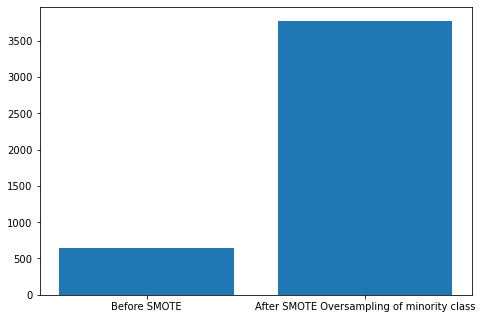

In [253]:
targets_oversampled = y_train_median_os.value_counts()
targets_wo_oversampling = y_train.value_counts()

figure = plt.figure()
axes = figure.add_axes([0,0,1,1])
target_values = ['Before SMOTE', 'After SMOTE Oversampling of minority class']
counts = [targets_wo_oversampling[1], targets_oversampled[1]]
axes.bar(target_values,counts)
plt.show()

In [254]:
# ### Standarizing all the columns.

# std_scaler = StandardScaler()
# columns = X_train_over_sampled.columns

# X_train_over_sampled = pd.DataFrame(std_scaler.fit_transform(X_train_over_sampled))
# X_cv = pd.DataFrame(std_scaler.transform(X_cv))
# X_test = pd.DataFrame(std_scaler.transform(X_test))

# X_train_over_sampled.columns = columns
# X_cv.columns = columns
# X_test.columns = columns


### Normalizing all the columns so as to make them free from various units

In [81]:
# Using the Min Max Scaler to normalise the values

mnmx_scaler = MinMaxScaler()
columns = X_train_median_os.columns

X_train_median_os = pd.DataFrame(mnmx_scaler.fit_transform(X_train_median_os))
X_cv_median = pd.DataFrame(mnmx_scaler.transform(X_cv_median))
X_test_median = pd.DataFrame(mnmx_scaler.transform(X_test_median))

X_train_median_os.columns = columns
X_cv_median.columns = columns
X_test_median.columns = columns

In [82]:
dump(mnmx_scaler, 'mnmx_scaler.joblib') 


['mnmx_scaler.joblib']

In [91]:
with open('mnmx_scaler.pkl', 'wb') as file:
    pickle.dump(mnmx_scaler, file)

In [83]:
X_train_median_os.head()

sensor1_measure  sensor3_measure  sensor4_measure  sensor5_measure  \
0         0.000927     1.407983e-08     2.329835e-09              0.0   
1         0.000568     1.595715e-08     3.727736e-09              0.0   
2         0.016780     7.133783e-08     9.319341e-09              0.0   
3         0.000006     6.570590e-09     6.989506e-10              0.0   
4         0.011829     1.182706e-07     2.842399e-08              0.0   

   sensor6_measure  sensor7_histogram_bin2  sensor7_histogram_bin3  \
0              0.0                     0.0                     0.0   
1              0.0                     0.0                     0.0   
2              0.0                     0.0                     0.0   
3              0.0                     0.0                     0.0   
4              0.0                     0.0                     0.0   

   sensor7_histogram_bin4  sensor7_histogram_bin5  sensor7_histogram_bin6  \
0            1.637019e-05                0.000994                0.009903   
1            8.565289e-07                0.000183                0.000488   
2            3.369305e-05                0.003132                0.020083   
3            3.059032e-07                0.000021                0.000027   
4            8.198205e-06                0.001170                0.013735   

   ...     SVD_1     SVD_2     SVD_3  sensor7_bin_average  \
0  ...  0.000221  0.000008  0.145609             0.002172   
1  ...  0.000210  0.000008  0.144753             0.000140   
2  ...  0.000398  0.000008  0.173272             0.004710   
3  ...  0.000207  0.000008  0.144444             0.000011   
4  ...  0.000274  0.000008  0.146614             0.003380   

   sensor24_bin_average  sensor25_bin_average  sensor26_bin_average  \
0              0.001082              0.001095              0.003015   
1              0.000141              0.000140              0.000140   
2              0.004712              0.004710              0.004710   
3              0.000011              0.000011              0.000011   
4              0.003381              0.003380              0.003380   

   sensor64_bin_average  sensor69_bin_average  sensor105_bin_average  
0              0.001486              0.003014               0.002657  
1              0.000159              0.000140               0.000140  
2              0.002966              0.004710               0.004710  
3              0.000013              0.000011               0.000011  
4              0.001891              0.003380               0.003380  

[5 rows x 154 columns]

In [257]:
# Using the Min Max Scaler to normalise the values

mnmx_scaler = MinMaxScaler()
columns = X_train_knn_os.columns

X_train_knn_os = pd.DataFrame(mnmx_scaler.fit_transform(X_train_knn_os))
X_cv_knn_imputation = pd.DataFrame(mnmx_scaler.transform(X_cv_knn_imputation))
X_test_knn_imputation = pd.DataFrame(mnmx_scaler.transform(X_test_knn_imputation))

X_train_knn_os.columns = columns
X_cv_knn_imputation.columns = columns
X_test_knn_imputation.columns = columns

In [258]:
X_train_knn_os.head()

sensor1_measure  sensor3_measure  sensor4_measure  sensor5_measure  \
0         0.014342     2.684555e-07     6.127467e-08              0.0   
1         0.000031     0.000000e+00     0.000000e+00              0.0   
2         0.000056     1.595715e-08     3.727736e-09              0.0   
3         0.014390     3.379160e-08     7.455473e-09              0.0   
4         0.014543     9.999998e-01     2.819101e-08              0.0   

   sensor6_measure  sensor7_histogram_bin2  sensor7_histogram_bin3  \
0              0.0                0.000000                0.000000   
1              0.0                0.000000                0.000000   
2              0.0                0.000021                0.000275   
3              0.0                0.000000                0.000006   
4              0.0                0.000000                0.000000   

   sensor7_histogram_bin4  sensor7_histogram_bin5  sensor7_histogram_bin6  \
0                0.000036                0.007690                0.019205   
1                0.000008                0.000078                0.000045   
2                0.000024                0.000015                0.000015   
3                0.000767                0.006076                0.010083   
4                0.000006                0.003011                0.012316   

   ...     SVD_1     SVD_2     SVD_3  sensor7_bin_average  \
0  ...  0.004513  0.000061  0.282686             0.006111   
1  ...  0.004272  0.000061  0.280631             0.000035   
2  ...  0.004271  0.000061  0.280627             0.000048   
3  ...  0.004455  0.000061  0.282401             0.004108   
4  ...  0.000189  0.000061  0.274487             0.004128   

   sensor24_bin_average  sensor25_bin_average  sensor26_bin_average  \
0              0.006113              0.006111              0.006111   
1              0.000035              0.000035              0.000035   
2              0.000048              0.000048              0.000048   
3              0.004109              0.004108              0.004108   
4              0.004129              0.004128              0.004128   

   sensor64_bin_average  sensor69_bin_average  sensor105_bin_average  
0              0.005361              0.006111               0.006111  
1              0.000041              0.000035               0.000035  
2              0.000052              0.000048               0.000048  
3              0.003873              0.004108               0.004108  
4              0.003274              0.004128               0.004128  

[5 rows x 154 columns]

# Take aways from EDA and FE


- There are multiple columns with majority of Null values and Zeros which have been removed.
- Columns with Null values less than 50% were imputed with Median values or KNN based imputation and used as two different datasets.
- Several sensors have highly distinguishable distributions namely Sensor 1, Sensor 35, Sensor 89, Sensor 8 and few more mentioned in detail above.
- Apart from the existing features, several features were added namely 4 features from the Truncated SVD of the entire imputed dataset of both median and Knn based imputations. Also Average of the bins per row for each sensor were added as new features.
- Post ML modelling, we can see how much contribution these features have added to each classification.

## -------------------------------------------------------------------------------------------------------------------------------------

# Non ML based Modelling

### Currently there are two datasets one with median imputation and knn imputation

### Random Model

In [262]:
# Random predictions of 1s and 0s.
def random_model(train_shape, cv_shape, test_shape):
    train = np.random.randint(2, size=train_shape)
    cv = np.random.randint(2, size=cv_shape)
    test = np.random.randint(2, size=test_shape)
    return train, cv, test

Random Model: Train F1 score: 0.3954899335055624
Random Model: CV F1 score: 0.3488472242359573
Random Model: Test F1 score: 0.34515454931099315


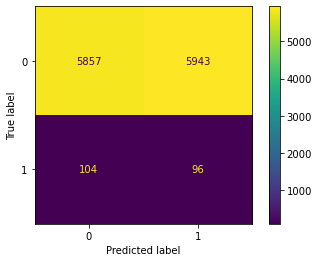

In [263]:
y_train_pred, y_cv_pred, y_test_pred = random_model(X_train_knn_os.shape[0], X_cv_knn_imputation.shape[0], X_test_knn_imputation.shape[0])

print("Random Model: Train F1 score:",f1_score(y_train_knn_os, y_train_pred, average='macro'))
print("Random Model: CV F1 score:",f1_score(y_cv, y_cv_pred, average='macro'))
print("Random Model: Test F1 score:",f1_score(y_test, y_test_pred, average='macro'))

cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

### Predicting All 1s

All 1s Model: Train F1 score: 0.08333333333333334
All 1s Model: CV F1 score: 0.01639344262295082
All 1s Model: Test F1 score: 0.01639344262295082


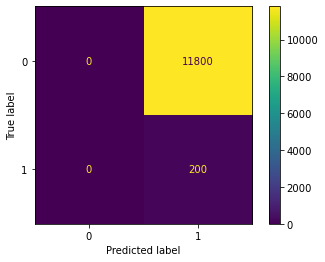

In [264]:
# Predict all the values as 1s
def model_ones(train_shape, cv_shape, test_shape):
    train = np.ones(train_shape)
    cv = np.ones(cv_shape)
    test = np.ones(test_shape)
    return train, cv, test

y_train_pred, y_cv_pred, y_test_pred = model_ones(X_train_knn_os.shape[0], X_cv_knn_imputation.shape[0], X_test_knn_imputation.shape[0])

print("All 1s Model: Train F1 score:",f1_score(y_train_knn_os, y_train_pred, average='macro'))
print("All 1s Model: CV F1 score:",f1_score(y_cv, y_cv_pred, average='macro'))
print("All 1s Model: Test F1 score:",f1_score(y_test, y_test_pred, average='macro'))

cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

#### Model predicting all 1s will result in a bad f1 score because the class with 1s is significantly low and hence the precision will be highly low and thus resulting in a low f1 score.

### Predicting all 0s

All 0s Model: Train F1 score: 0.47619047619047616
All 0s Model: CV F1 score: 0.49579831932773105
All 0s Model: Test F1 score: 0.49579831932773105


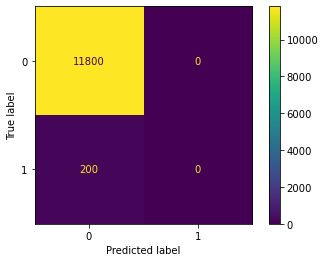

In [265]:
# Predict all the values as Zeros
def model_zeros(train_shape, cv_shape, test_shape):
    train = np.zeros(train_shape)
    cv = np.zeros(cv_shape)
    test = np.zeros(test_shape)
    return train, cv, test

y_train_pred, y_cv_pred, y_test_pred = model_zeros(X_train_knn_os.shape[0], X_cv_knn_imputation.shape[0], X_test_knn_imputation.shape[0])

print("All 0s Model: Train F1 score:",f1_score(y_train_knn_os, y_train_pred, average='macro'))
print("All 0s Model: CV F1 score:",f1_score(y_cv, y_cv_pred, average='macro'))
print("All 0s Model: Test F1 score:",f1_score(y_test, y_test_pred, average='macro'))

cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

#### When predicting all zeros we tend to get a f1 score of ~0.5 this is to the fact that the entire minority class is getting misclassified.

In [266]:
X_train_knn_os.head()

sensor1_measure  sensor3_measure  sensor4_measure  sensor5_measure  \
0         0.014342     2.684555e-07     6.127467e-08              0.0   
1         0.000031     0.000000e+00     0.000000e+00              0.0   
2         0.000056     1.595715e-08     3.727736e-09              0.0   
3         0.014390     3.379160e-08     7.455473e-09              0.0   
4         0.014543     9.999998e-01     2.819101e-08              0.0   

   sensor6_measure  sensor7_histogram_bin2  sensor7_histogram_bin3  \
0              0.0                0.000000                0.000000   
1              0.0                0.000000                0.000000   
2              0.0                0.000021                0.000275   
3              0.0                0.000000                0.000006   
4              0.0                0.000000                0.000000   

   sensor7_histogram_bin4  sensor7_histogram_bin5  sensor7_histogram_bin6  \
0                0.000036                0.007690                0.019205   
1                0.000008                0.000078                0.000045   
2                0.000024                0.000015                0.000015   
3                0.000767                0.006076                0.010083   
4                0.000006                0.003011                0.012316   

   ...     SVD_1     SVD_2     SVD_3  sensor7_bin_average  \
0  ...  0.004513  0.000061  0.282686             0.006111   
1  ...  0.004272  0.000061  0.280631             0.000035   
2  ...  0.004271  0.000061  0.280627             0.000048   
3  ...  0.004455  0.000061  0.282401             0.004108   
4  ...  0.000189  0.000061  0.274487             0.004128   

   sensor24_bin_average  sensor25_bin_average  sensor26_bin_average  \
0              0.006113              0.006111              0.006111   
1              0.000035              0.000035              0.000035   
2              0.000048              0.000048              0.000048   
3              0.004109              0.004108              0.004108   
4              0.004129              0.004128              0.004128   

   sensor64_bin_average  sensor69_bin_average  sensor105_bin_average  
0              0.005361              0.006111               0.006111  
1              0.000041              0.000035               0.000035  
2              0.000052              0.000048               0.000048  
3              0.003873              0.004108               0.004108  
4              0.003274              0.004128               0.004128  

[5 rows x 154 columns]

 ### Model based on percentiles of certain sensors where classes can be seperated based on percentile values

In [267]:

sensor_names = ['sensor1_measure', 'sensor8_measure', 'sensor14_measure', 'sensor15_measure', 'sensor16_measure', 'sensor17_measure', 'sensor27_measure', 'sensor33_measure', 'sensor34_measure', 'sensor35_measure', 'sensor59_measure', 'sensor61_measure', 'sensor89_measure']

def sensor_based_prediction(X_train, X_cv, X_test, y_true, y_cv, y_test):
    train_f1_scores = []
    cv_f1_scores = []
    test_f1_scores = []
    final_test_score = dict()
    
    X_train['label'] = y_true
    
    df_0 = X_train[X_train['label']==0]
    df_1 = X_train[X_train['label']==1]
    
    df_0 = df_0[sensor_names]
    df_1 = df_1[sensor_names]
    
    quantiles_0 = df_0.quantile([0.1, 0.9], axis=0)
    quantiles_1 = df_1.quantile([0.1, 0.9], axis=0)
    
    # For each sensor column
    for sensor_name in sensor_names:
        y_train_pred = []
        y_cv_pred = []
        y_test_pred = []
        
        # If the value is less than the (90th 0 quantile + 10th 1 quantile)/2 then set the value as class 0 else it is class 1
        for value in X_train[sensor_name]:
            if value <= ((quantiles_0[sensor_name][0.9] + quantiles_1[sensor_name][0.1])/2):
                y_train_pred.append(0)
            else:
                y_train_pred.append(1)
                
        # Loop same for CV dataset
        for value in X_cv[sensor_name]:
            if value <= ((quantiles_0[sensor_name][0.9] + quantiles_1[sensor_name][0.1])/2):
                y_cv_pred.append(0)
            else:
                y_cv_pred.append(1)
        
        # Loop same for test dataset
        for value in X_test[sensor_name]:
            if value <= ((quantiles_0[sensor_name][0.9] + quantiles_1[sensor_name][0.1])/2):
                y_test_pred.append(0)
            else:
                y_test_pred.append(1)
        
        print(sensor_name, ": f1 score :", f1_score(y_true, np.array(y_train_pred), average='macro'),\
              f1_score(y_cv, np.array(y_cv_pred), average='macro'),\
              f1_score(y_test, np.array(y_test_pred), average='macro'))
        
        final_test_score[sensor_name] = f1_score(y_test, np.array(y_test_pred), average='macro')
    return final_test_score

## For KNN based imputation

In [268]:
f1_scores_knn_os = sensor_based_prediction(X_train_knn_os, X_cv_knn_imputation, X_test_knn_imputation, y_train_knn_os, y_cv, y_test)

sensor1_measure : f1 score : 0.8392404400336879 0.6411781508446548 0.6370955038841728
sensor8_measure : f1 score : 0.8382468950054894 0.6338964165622077 0.6403446867169934
sensor14_measure : f1 score : 0.83360435382083 0.6325353729138072 0.6349116763598877
sensor15_measure : f1 score : 0.831467014517093 0.6280986399486914 0.6309542949768017
sensor16_measure : f1 score : 0.8454179995588668 0.6491017806244606 0.6482715959354153
sensor17_measure : f1 score : 0.8414696603947202 0.6420496134874315 0.6409016107296652
sensor27_measure : f1 score : 0.8413643303752081 0.6387312162529659 0.6432553830228016
sensor33_measure : f1 score : 0.8448099025593121 0.6453090161367632 0.6428390242070268
sensor34_measure : f1 score : 0.8125875259245186 0.6077035236155022 0.6123524514860155
sensor35_measure : f1 score : 0.8564995350923799 0.659524926293219 0.6556266873818059
sensor59_measure : f1 score : 0.8448018518379279 0.6433407063167239 0.6433747688259343
sensor61_measure : f1 score : 0.8497158842405399 

#### We see that Sensor 35, Sensor 61 and Sensor 89 are the top 3 f1 scores. Thus these may seem to be more important in deciding the class when a ML based Model is used

## For Median based imputation

In [269]:
f1_scores_median_os = sensor_based_prediction(X_train_median_os, X_cv_median, X_test_median, y_train_median_os, y_cv, y_test)

sensor1_measure : f1 score : 0.8382836099410816 0.6401773238651784 0.637062345399287
sensor8_measure : f1 score : 0.803016537961327 0.6020724172797038 0.6100458309397678
sensor14_measure : f1 score : 0.7935907054071094 0.5927326282309382 0.6034836480818796
sensor15_measure : f1 score : 0.7957787886835679 0.5936590256066746 0.6031271619770343
sensor16_measure : f1 score : 0.8152978741177985 0.6137094358339258 0.6235444690157617
sensor17_measure : f1 score : 0.8081199605122134 0.607787595193219 0.6118771290965237
sensor27_measure : f1 score : 0.8048228617377984 0.6043599037690457 0.6136347637032781
sensor33_measure : f1 score : 0.811718316953816 0.6096877038038664 0.6172884490019508
sensor34_measure : f1 score : 0.7861345872890244 0.5873315759065085 0.5926264924867657
sensor35_measure : f1 score : 0.8338366969306934 0.6312434592331843 0.6350877192982456
sensor59_measure : f1 score : 0.843226448022774 0.6432080289777635 0.6437002213499
sensor61_measure : f1 score : 0.8489147319150254 0.64

#### For median based imputation, we see that Sensor 61, Sensor 59, Sensor 1 and Sensor 35 are the important sensor based on the F1 scores alone.

### We can also conclude that the KNN based imputation provided a slightly better imputation, the same result can also be seen in their respective F1 score of each sensors.

## -------------------------------------------------------------------------------------------------------------------------------------

In [270]:
X_train_median_os = X_train_median_os.drop(['label'], axis=1)
X_train_knn_os = X_train_knn_os.drop(['label'], axis=1)

# ML Modelling

# KNN

### Median imputed data

In [93]:
# KNN with Random Search CV for hyper parameter tuning
x_cfl=KNeighborsClassifier()

params={
     'n_neighbors':[3, 4, 10, 20, 50],
     'weights':['uniform','distance'],
    'metric':['euclidean', 'manhattan']
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=params,n_jobs=-1,cv=3, scoring = "f1")
random_cfl.fit(X_train_median_os, y_train_median_os.values.ravel())

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [3, 4, 10, 20, 50],
                                        'weights': ['uniform', 'distance']},
                   scoring='f1')

{'weights': 'distance', 'n_neighbors': 50, 'metric': 'euclidean'} : 0.872862654722101
{'weights': 'distance', 'n_neighbors': 20, 'metric': 'euclidean'} : 0.9008407153868565
{'weights': 'uniform', 'n_neighbors': 4, 'metric': 'manhattan'} : 0.9473369503530846
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'euclidean'} : 0.9340275753277244
{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan'} : 0.9461240609187334
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'} : 0.954419090267396
{'weights': 'uniform', 'n_neighbors': 50, 'metric': 'euclidean'} : 0.8357271754035449
{'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'} : 0.918749379486142
{'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'} : 0.9301674333115842
{'weights': 'distance', 'n_neighbors': 20, 'metric': 'manhattan'} : 0.9219842058554583


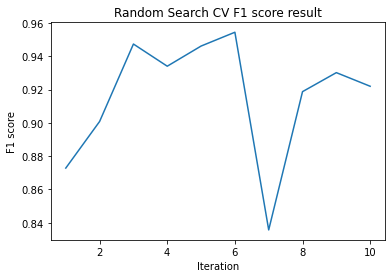

In [94]:
# Displaying mean test score which is the mean F1 score for each hyper parameter combination

labels = random_cfl.cv_results_['params']
x_axis = range(1,11)
y_axis = random_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

In [95]:
random_cfl.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')

In [274]:
x_cfl=KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
x_cfl.fit(X_train_median_os,y_train_median_os.values.ravel())

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [275]:
predict_y = x_cfl.predict(X_train_median_os)
print ("Train F1 score:",f1_score(y_train_median_os, predict_y, average='macro'))
predict_y = x_cfl.predict(X_cv_median)
print("CV F1 score:",f1_score(y_cv, predict_y, average='macro'))
predict_y = x_cfl.predict(X_test_median)
print("Test F1 score:",f1_score(y_test, predict_y, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.8389358885936954
Test F1 score: 0.8476016595496895


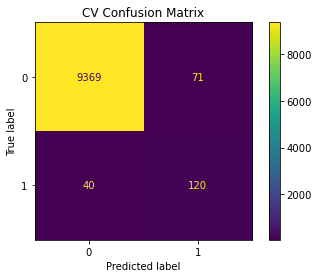

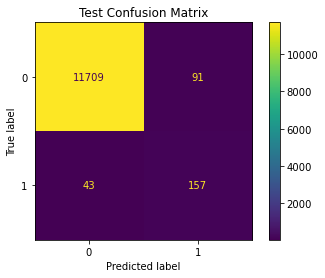

In [276]:
plot1 = plot_confusion_matrix(x_cfl, X_cv_median, y_cv) 
plot1.ax_.set_title('CV Confusion Matrix')

plot2 = plot_confusion_matrix(x_cfl, X_test_median, y_test) 
plot2.ax_.set_title('Test Confusion Matrix')

plt.show()

### KNN imputed data

In [277]:
# KNN with Random Search CV for hyper parameter tuning

x_cfl=KNeighborsClassifier()

params={
     'n_neighbors':[3, 4, 10, 20, 50],
     'weights':['uniform','distance'],
    'metric':['euclidean', 'manhattan']
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=params,n_jobs=-1,cv=3, scoring = "f1")
random_cfl.fit(X_train_knn_os, y_train_knn_os.values.ravel())

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [3, 4, 10, 20, 50],
                                        'weights': ['uniform', 'distance']},
                   scoring='f1')

{'weights': 'uniform', 'n_neighbors': 20, 'metric': 'euclidean'} : 0.8661704332051721
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'} : 0.9456862964172581
{'weights': 'uniform', 'n_neighbors': 4, 'metric': 'manhattan'} : 0.9374586053880373
{'weights': 'uniform', 'n_neighbors': 4, 'metric': 'euclidean'} : 0.9178782403132466
{'weights': 'uniform', 'n_neighbors': 50, 'metric': 'euclidean'} : 0.8369168868139387
{'weights': 'distance', 'n_neighbors': 10, 'metric': 'manhattan'} : 0.9326041150148586
{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'euclidean'} : 0.9185549877523345
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'euclidean'} : 0.9279061621579722
{'weights': 'uniform', 'n_neighbors': 10, 'metric': 'euclidean'} : 0.8864014724160091
{'weights': 'distance', 'n_neighbors': 50, 'metric': 'euclidean'} : 0.8704944230285304


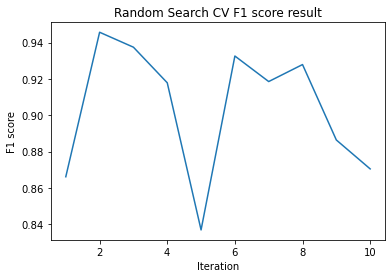

In [278]:
# Displaying mean test score which is the mean F1 score for each hyper parameter combination

labels = random_cfl.cv_results_['params']
x_axis = range(1,11)
y_axis = random_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

In [279]:
random_cfl.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')

In [280]:
x_cfl=KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')
x_cfl.fit(X_train_knn_os,y_train_knn_os.values.ravel())

KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')

In [281]:
predict_y = x_cfl.predict(X_train_knn_os)
print ("Train F1 score:",f1_score(y_train_knn_os, predict_y, average='macro'))
predict_y = x_cfl.predict(X_cv_knn_imputation)
print("CV F1 score:",f1_score(y_cv, predict_y, average='macro'))
predict_y = x_cfl.predict(X_test_knn_imputation)
print("Test F1 score:",f1_score(y_test, predict_y, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.8450416796375082
Test F1 score: 0.8309656870885478


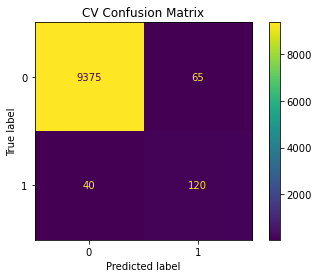

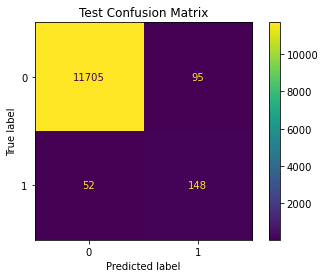

In [282]:
plot1 = plot_confusion_matrix(x_cfl, X_cv_knn_imputation, y_cv) 
plot1.ax_.set_title('CV Confusion Matrix')

plot2 = plot_confusion_matrix(x_cfl, X_test_knn_imputation, y_test) 
plot2.ax_.set_title('Test Confusion Matrix')

plt.show()

### For KNN, We see that Median based imputations provided slightly better results compared to the KNN based imputation dataset.

### However for the minority class, both the median based imputation dataset provided better classification.

## -------------------------------------------------------------------------------------------------------------------------------------

# Random Forest Classifier

### Median Imputed Data

In [96]:
# Random Forest Classifier with Random Search CV for hyper parameter tuning

x_cfl=RandomForestClassifier()

params={
    'n_estimators': [100, 200, 400, 800, 1000, 1500, 2000],
    'max_depth': [5, 10, 20, 40, 100, 200], 
    'min_samples_split': [2, 5, 10],
}
random_cfl = RandomizedSearchCV(x_cfl,param_distributions=params,n_jobs=-1,cv=3, scoring = "f1")
random_cfl.fit(X_train_median_os, y_train_median_os.values.ravel())

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, 40, 100, 200],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400, 800,
                                                         1000, 1500, 2000]},
                   scoring='f1')

{'n_estimators': 1500, 'min_samples_split': 2, 'max_depth': 10} : 0.9413489939937105
{'n_estimators': 2000, 'min_samples_split': 2, 'max_depth': 100} : 0.9562310117071752
{'n_estimators': 400, 'min_samples_split': 5, 'max_depth': 10} : 0.9413424463493959
{'n_estimators': 1500, 'min_samples_split': 5, 'max_depth': 40} : 0.9529810175765885
{'n_estimators': 800, 'min_samples_split': 5, 'max_depth': 5} : 0.8872108969284476
{'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 200} : 0.954722729825244
{'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 10} : 0.9413749237154313
{'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 20} : 0.9479218234822366
{'n_estimators': 2000, 'min_samples_split': 2, 'max_depth': 5} : 0.887270347367271
{'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 5} : 0.8871448967638166


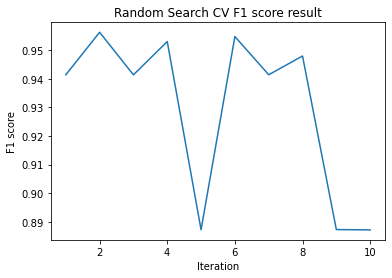

In [97]:
# Displaying mean test score which is the mean F1 score for each hyper parameter combination

labels = random_cfl.cv_results_['params']
x_axis = range(1,11)
y_axis = random_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

In [98]:
random_cfl.best_estimator_

RandomForestClassifier(max_depth=100, n_estimators=2000)

In [286]:
x_cfl = RandomForestClassifier(max_depth=100, n_estimators=1500)
x_cfl.fit(X_train_median_os,y_train_median_os.values.ravel())

RandomForestClassifier(max_depth=100, n_estimators=1500)

In [287]:
predict_y = x_cfl.predict(X_train_median_os)
print ("Train F1 score:",f1_score(y_train_median_os, predict_y, average='macro'))
predict_y = x_cfl.predict(X_cv_median)
print("CV F1 score:",f1_score(y_cv, predict_y, average='macro'))
predict_y = x_cfl.predict(X_test_median)
print("Test F1 score:",f1_score(y_test, predict_y, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.9085853431499399
Test F1 score: 0.8895924162828078


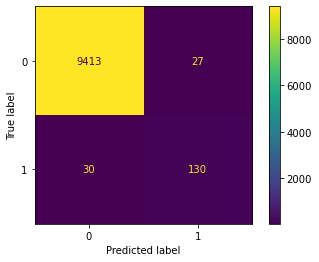

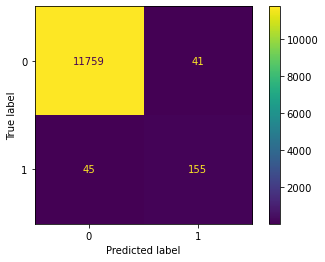

In [288]:
plot_confusion_matrix(x_cfl, X_cv_median, y_cv) 
plot_confusion_matrix(x_cfl, X_test_median, y_test) 

### KNN Imputed data

In [289]:
# Random Forest Classifier with Random Search CV for hyper parameter tuning

x_cfl = RandomForestClassifier()

params={
    'n_estimators': [100, 200, 400, 800, 1000, 1500, 2000],
    'max_depth': [5, 10, 20, 40, 100, 200], 
    'min_samples_split': [2, 5, 10],
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=params,verbose=10,n_jobs=-1,cv=3)
random_cfl.fit(X_train_knn_os, y_train_knn_os.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  5.9min remaining: 10.3min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  6.3min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  6.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  7.7min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  8.3min remaining:   54.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, 40, 100, 200],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400, 800,
                                                         1000, 1500, 2000]},
                   verbose=10)

{'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 100} : 0.991043953696512
{'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10} : 0.9878659875911332
{'n_estimators': 1500, 'min_samples_split': 10, 'max_depth': 100} : 0.990008704843721
{'n_estimators': 1500, 'min_samples_split': 10, 'max_depth': 10} : 0.987553000284597
{'n_estimators': 1000, 'min_samples_split': 5, 'max_depth': 10} : 0.9880345097209479
{'n_estimators': 1500, 'min_samples_split': 10, 'max_depth': 5} : 0.9766708762422173
{'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 40} : 0.9907550529034742
{'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 10} : 0.9874326390098475
{'n_estimators': 1500, 'min_samples_split': 2, 'max_depth': 10} : 0.9882993379112662
{'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 5} : 0.9771283095981539


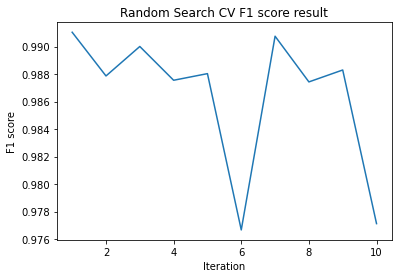

In [290]:
labels = random_cfl.cv_results_['params']
x_axis = range(1,11)
y_axis = random_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

In [291]:
random_cfl.best_estimator_

RandomForestClassifier(max_depth=100, n_estimators=1000)

In [292]:
x_cfl = RandomForestClassifier(max_depth=100, n_estimators=1000)
x_cfl.fit(X_train_knn_os,y_train_knn_os.values.ravel())

RandomForestClassifier(max_depth=100, n_estimators=1000)

In [293]:
predict_y = x_cfl.predict(X_train_knn_os)
print ("Train F1 score:",f1_score(y_train_knn_os, predict_y, average='macro'))
predict_y = x_cfl.predict(X_cv_knn_imputation)
print("CV F1 score:",f1_score(y_cv, predict_y, average='macro'))
predict_y = x_cfl.predict(X_test_knn_imputation)
print("Test F1 score:",f1_score(y_test, predict_y, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.9028701204882665
Test F1 score: 0.879104580928921


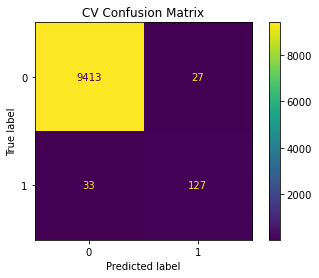

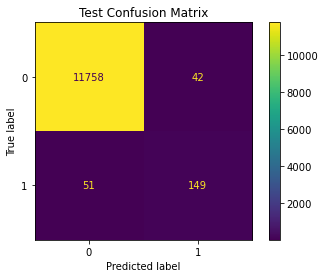

In [294]:
plot1 = plot_confusion_matrix(x_cfl, X_cv_knn_imputation, y_cv) 
plot1.ax_.set_title('CV Confusion Matrix')

plot2 = plot_confusion_matrix(x_cfl, X_test_knn_imputation, y_test) 
plot2.ax_.set_title('Test Confusion Matrix')

plt.show()

### The RF classifier with Median based imputation provided slightly better classification over the KNN based imputation dataset.

### From KNN Models, RF classifier overall performed better overall but for the minority class, KNN Model had better performance and lesser misclassification.

## -------------------------------------------------------------------------------------------------------------------------------------

# XG Boost Classifier

### Median Imputed Data

In [99]:
# XG Boost Classifier with Random Search CV for hyper parameter tuning

x_cfl=XGBClassifier()

params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 500, 1000, 2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=params,n_jobs=-1,cv=3)
random_cfl.fit(X_train_median_os, y_train_median_os.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                    

{'subsample': 0.1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5} : 0.9897198683880352
{'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.5} : 0.9936441669035411
{'subsample': 0.3, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.5} : 0.9783802744739244
{'subsample': 0.3, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1} : 0.9933311969854786
{'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.1} : 0.9939330763908157
{'subsample': 1, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.15, 'colsample_bytree': 0.1} : 0.9934034582648206
{'subsample': 0.1, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15, 'colsample_bytree': 0.1} : 0.9905143842582428
{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.1} : 0.9934275065236772
{'su

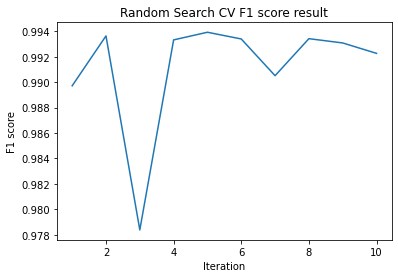

In [100]:
# Displaying mean test score which is the mean F1 score for each hyper parameter combination

labels = random_cfl.cv_results_['params']
x_axis = range(1,11)
y_axis = random_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

In [101]:
random_cfl.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [298]:
from sklearn.calibration import CalibratedClassifierCV
x_cfl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
x_cfl.fit(X_train_median_os,y_train_median_os.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [299]:
predict_y = x_cfl.predict(X_train_median_os)
print ("Train F1 score:",f1_score(y_train_median_os, predict_y, average='macro'))
predict_y = x_cfl.predict(X_cv_median)
print("CV F1 score:",f1_score(y_cv, predict_y, average='macro'))
predict_y = x_cfl.predict(X_test_median)
print("Test F1 score:",f1_score(y_test, predict_y, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.9136565815063191
Test F1 score: 0.8878106860321554


With Calibrate classifier
Train F1 score: 0.99
CV F1 score: 0.906
Test F1 score: 0.883

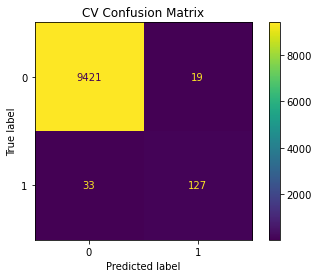

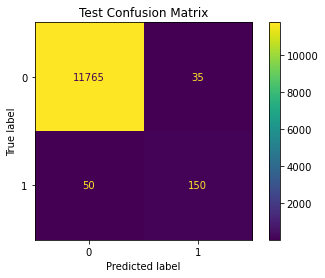

In [300]:
plot1 = plot_confusion_matrix(x_cfl, X_cv_median, y_cv) 
plot1.ax_.set_title('CV Confusion Matrix')

plot2 = plot_confusion_matrix(x_cfl, X_test_median, y_test) 
plot2.ax_.set_title('Test Confusion Matrix')

plt.show()

### KNN Imputed Data

In [301]:
# XG Boost Classifier with Random Search CV for hyper parameter tuning

x_cfl=XGBClassifier()

params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 500, 1000, 2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl, param_distributions=params, n_jobs=-1, cv=3)
random_cfl.fit(X_train_knn_os, y_train_knn_os.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                    

{'subsample': 0.5, 'n_estimators': 2000, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.3} : 0.9934997365037667
{'subsample': 0.5, 'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 1} : 0.9931145313890725
{'subsample': 0.5, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.15, 'colsample_bytree': 0.1} : 0.9931626818110533
{'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.15, 'colsample_bytree': 0.3} : 0.9932589843938624
{'subsample': 0.5, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.15, 'colsample_bytree': 0.3} : 0.9933552765435874
{'subsample': 1, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 1} : 0.9920792877528234
{'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 1} : 0.9916699926469362
{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5} : 0.9826416189879071
{'s

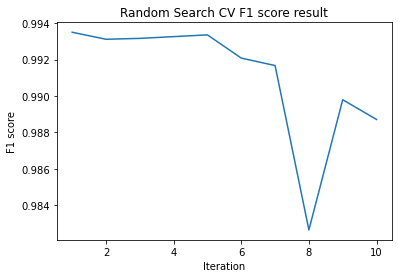

In [302]:
# Displaying mean test score which is the mean F1 score for each hyper parameter combination

labels = random_cfl.cv_results_['params']
x_axis = range(1,11)
y_axis = random_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

In [304]:
random_cfl.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [305]:
x_cfl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)
x_cfl.fit(X_train_knn_os,y_train_knn_os.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [306]:
predict_y = x_cfl.predict(X_train_knn_os)
print ("Train F1 score:",f1_score(y_train_knn_os, predict_y, average='macro'))
predict_y = x_cfl.predict(X_cv_knn_imputation)
print("CV F1 score:",f1_score(y_cv, predict_y, average='macro'))
predict_y = x_cfl.predict(X_test_knn_imputation)
print("Test F1 score:",f1_score(y_test, predict_y, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.9147526426339248
Test F1 score: 0.8778757070159422


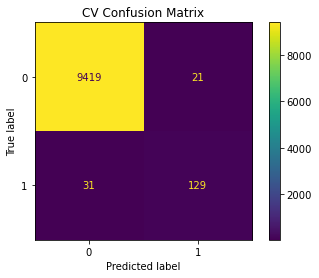

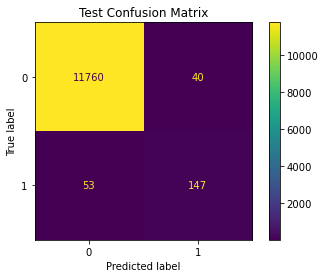

In [307]:
plot1 = plot_confusion_matrix(x_cfl, X_cv_knn_imputation, y_cv) 
plot1.ax_.set_title('CV Confusion Matrix')

plot2 = plot_confusion_matrix(x_cfl, X_test_knn_imputation, y_test) 
plot2.ax_.set_title('Test Confusion Matrix')

plt.show()

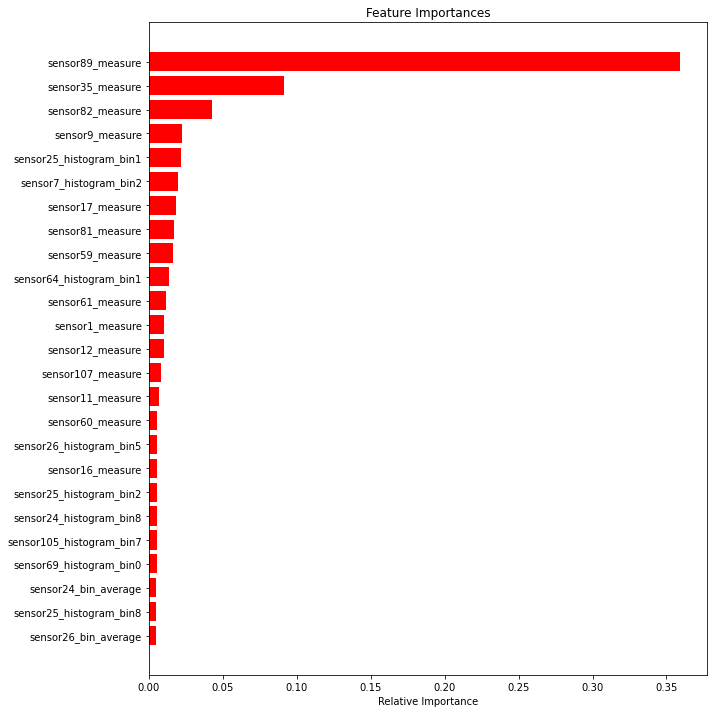

In [308]:
# Fetching the feature importances from the classifier and plotting the top 25 feature importances
features = X_train_knn_os.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Comments for XG Boost

- XG Boost Model provided slightly better results over the RF classifier mainly for the Majority class, whereas the classification of the minority class remains the same.

- We see that FE of Averaging Bin values has good feature importance and in the top 25 features of the 150+ features.

- We can try improving using stacking and voting classifier to see if they can classify better.

### Since XG Boost provided good results, we can try for the non oversampled dataset with XG Boost for the knn based imputation to see if dataset without oversampling can do better than oversampling.

In [309]:
mnmx_scaler = MinMaxScaler()
columns = X_train_knn_imputation.columns

X_train_knn_wo_os = pd.DataFrame(mnmx_scaler.fit_transform(X_train_knn_imputation))
X_cv_knn_wo_os = pd.DataFrame(mnmx_scaler.transform(X_cv_knn_imputation))
X_test_knn_wo_os = pd.DataFrame(mnmx_scaler.transform(X_test_knn_imputation))

X_train_knn_wo_os.columns = columns
X_cv_knn_wo_os.columns = columns
X_test_knn_wo_os.columns = columns

In [310]:
x_cfl=XGBClassifier()

params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 500, 1000, 2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl, param_distributions=params, n_jobs=-1, cv=3)
random_cfl.fit(X_train_knn_wo_os, y_train.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                    

{'subsample': 0.3, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.15, 'colsample_bytree': 0.3} : 0.9932552083333333
{'subsample': 1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.1} : 0.9919791666666667
{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.15, 'colsample_bytree': 1} : 0.993203125
{'subsample': 0.5, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.3} : 0.9932552083333334
{'subsample': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 1} : 0.9932552083333333
{'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1} : 0.9937239583333333
{'subsample': 0.5, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15, 'colsample_bytree': 0.5} : 0.9932291666666666
{'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.3} : 0.9933593749999999
{'subsample':

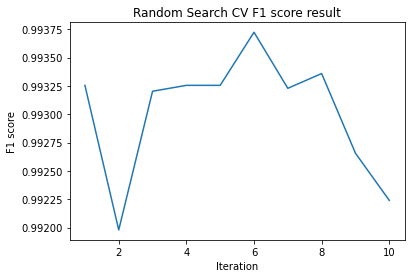

In [311]:
labels = random_cfl.cv_results_['params']
x_axis = range(1,11)
y_axis = random_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

In [312]:
random_cfl.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [313]:
x_cfl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
x_cfl.fit(X_train_knn_wo_os,y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [314]:
predict_y = x_cfl.predict(X_train_knn_wo_os)
print ("Train F1 score:",f1_score(y_train, predict_y, average='macro'))
predict_y = x_cfl.predict(X_cv_knn_wo_os)
print("CV F1 score:",f1_score(y_cv, predict_y, average='macro'))
predict_y = x_cfl.predict(X_test_knn_wo_os)
print("Test F1 score:",f1_score(y_test, predict_y, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.49579831932773105
Test F1 score: 0.49579831932773105


#### The non oversampled data provided did not give good results and the minority class has been misclassified significantly.

### Next we use the Stacking and Voting classifiers in which we use the existing RandomSearch CV best results obtained from the above 3 models of KNN, RF and XG Boost.

## -------------------------------------------------------------------------------------------------------------------------------------

## Stacking Classifier

### Median Imputed Data

In [315]:
# Using 3 Stacking classifiers and one meta classifier with best hyperparameters obtained from the above 
# individual classifiers hyperparameters tuning.

clf1 = RandomForestClassifier(max_depth=100, n_estimators=1500)
clf2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
clf3 =  KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=False,
                          average_probas=False,
                          meta_classifier=knn)


sclf.fit(X_train_median_os, y_train_median_os.values.ravel())

y_train_pred = sclf.predict(X_train_median_os)
print("Train F1 score:", f1_score(y_train_median_os, y_train_pred, average='macro'))

y_cv_pred = sclf.predict(X_cv_median)
print("CV F1 score:", f1_score(y_cv, y_cv_pred, average='macro'))

y_test_pred = sclf.predict(X_test_median)
print("Test F1 score:", f1_score(y_test, y_test_pred, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.9152901313002965
Test F1 score: 0.8947039898413183


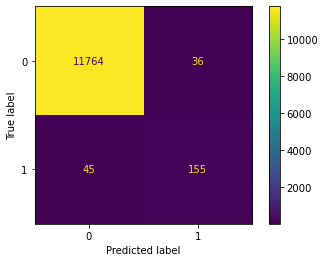

In [316]:
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

### KNN imputed Data

In [318]:
# Using 3 Stacking classifiers and one meta classifier with best hyperparameters obtained from the above 
# individual classifiers hyperparameters tuning.

clf1 = RandomForestClassifier(max_depth=100, n_estimators=1000)
clf2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)
clf3 =  KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=False,
                          average_probas=False,
                          meta_classifier=knn)

sclf.fit(X_train_knn_os, y_train_knn_os.values.ravel())

y_train_pred = sclf.predict(X_train_knn_os)
print("Train F1 score:", f1_score(y_train_knn_os, y_train_pred, average='macro'))

y_cv_pred = sclf.predict(X_cv_knn_imputation)
print("CV F1 score:", f1_score(y_cv,y_cv_pred, average='macro'))

y_test_pred = sclf.predict(X_test_knn_imputation)
print("Test F1 score:", f1_score(y_test, y_test_pred, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.9068513139633319
Test F1 score: 0.891558540042608


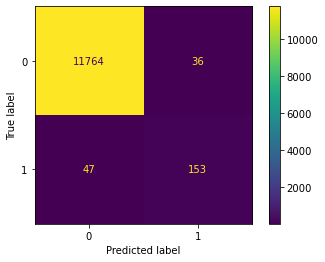

In [319]:
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

### The stacking classifier of the Median and KNN based imputation improved its performance over the XG Boost and provided better classifications for the majority class and thus there is a slight increase in the F1 score.

### The Median based imputation performed marginally better over the KNN imputed dataset.

## -------------------------------------------------------------------------------------------------------------------------------------

## Voting Classifier

### Median Imputed Data

In [102]:
# Using 3 Voting classifiers and hard voting with best hyperparameters obtained from the above 
# individual classifiers hyperparameters tuning.

rf = RandomForestClassifier(max_depth=100, n_estimators=2000)
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
knn =  KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')

clf = VotingClassifier(estimators=[('rf', rf), ('xbg', xgb), ('knn', knn)], voting='hard',n_jobs=-1)

clf.fit(X_train_median_os, y_train_median_os.values.ravel())

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=100,
                                                     n_estimators=2000)),
                             ('xbg',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=10, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=1000, n_

In [103]:
y_train_pred = clf.predict(X_train_median_os)
print("Train F1 score:", f1_score(y_train_median_os, y_train_pred, average='macro'))

y_cv_pred = clf.predict(X_cv_median)
print("CV F1 score:", f1_score(y_cv,y_cv_pred, average='macro'))

y_test_pred = clf.predict(X_test_median)
print("Test F1 score:", f1_score(y_test, y_test_pred, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.8789666780135406
Test F1 score: 0.8696771250773793


In [92]:
with open('rf.pkl', 'wb') as file:
    pickle.dump(rf, file)
    
with open('xgb.pkl', 'wb') as file:
    pickle.dump(xgb, file)

with open('knn.pkl', 'wb') as file:
    pickle.dump(knn, file)

with open('clf_voting_classifier.pkl', 'wb') as file:
    pickle.dump(clf, file)

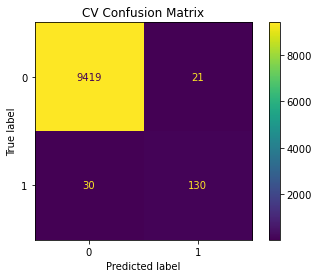

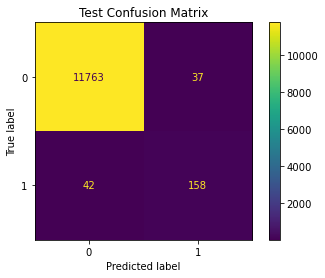

In [322]:
plot1 = plot_confusion_matrix(clf, X_cv_median, y_cv) 
plot1.ax_.set_title('CV Confusion Matrix')

plot2 = plot_confusion_matrix(clf, X_test_median, y_test) 
plot2.ax_.set_title('Test Confusion Matrix')

plt.show()

### KNN imputed Data

In [323]:
# Using 3 Voting classifiers and hard voting with best hyperparameters obtained from the above 
# individual classifiers hyperparameters tuning.

rf = RandomForestClassifier(max_depth=100, n_estimators=1000)
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)
knn =  KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')

clf = VotingClassifier(estimators=[('rf', rf), ('xbg', xgb), ('knn', knn)], voting='hard',n_jobs=-1)

clf.fit(X_train_knn_os, y_train_knn_os.values.ravel())

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=100,
                                                     n_estimators=1000)),
                             ('xbg',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.3, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.2, max_delta_step=0,
                                            max_depth=10, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=2000, n_

In [324]:
y_train_pred = clf.predict(X_train_knn_os)
print("Train F1 score:", f1_score(y_train_knn_os, y_train_pred, average='macro'))

y_cv_pred = clf.predict(X_cv_knn_imputation)
print("CV F1 score:", f1_score(y_cv,y_cv_pred, average='macro'))

y_test_pred = clf.predict(X_test_knn_imputation)
print("Test F1 score:", f1_score(y_test, y_test_pred, average='macro'))

Train F1 score: 1.0
CV F1 score: 0.9035829390146769
Test F1 score: 0.889973820755129


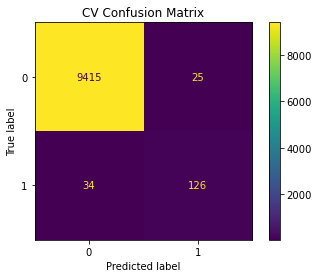

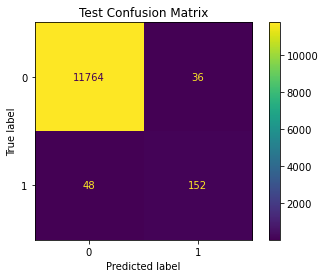

In [325]:
plot1 = plot_confusion_matrix(clf, X_cv_knn_imputation, y_cv) 
plot1.ax_.set_title('CV Confusion Matrix')

plot2 = plot_confusion_matrix(clf, X_test_knn_imputation, y_test) 
plot2.ax_.set_title('Test Confusion Matrix')

plt.show()

### Voting Classifiers also provided similar results as the stacking classifier. The Median based imputation + Voting classifier provided the best result till now with an test F1 score of 0.898.

## -------------------------------------------------------------------------------------------------------------------------------------

# Ensemble Model 

# with Decision Tree and Logistic Regression as the metaclassifier

### Without feature engineering data

In [332]:
X_train, X_ensemble_test, y_train, y_ensemble_test = train_test_split(data_df, y_true, stratify=y_true, test_size=0.2)

dataset_d1, dataset_d2, y_d1, y_d2 = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5)

print(dataset_d1.shape, dataset_d2.shape, X_ensemble_test.shape)

(24000, 149) (24000, 149) (12000, 149)


In [333]:
high_correlated_columns = ['sensor45_measure', 'sensor32_measure', 'sensor46_measure', 'sensor47_measure', 'sensor67_measure']
for column in high_correlated_columns:
    if column in X_train.columns:
        dataset_d1 = dataset_d1.drop([column],axis=1)
        dataset_d2 = dataset_d2.drop([column],axis=1)
        X_ensemble_test = X_ensemble_test.drop([column],axis=1)
        
dataset_d1 = dataset_d1.drop(['sensor64_histogram_bin5'],axis=1)
dataset_d2 = dataset_d2.drop(['sensor64_histogram_bin5'],axis=1)
X_ensemble_test = X_ensemble_test.drop(['sensor64_histogram_bin5'],axis=1)

In [335]:
knn_imputer = KNNImputer(weights="distance")
columns = dataset_d1.columns
dataset_d1 = knn_imputer.fit_transform(dataset_d1)
dataset_d2 = knn_imputer.transform(dataset_d2)
X_ensemble_test = knn_imputer.transform(X_ensemble_test)

print(dataset_d1.shape, dataset_d2.shape, X_ensemble_test.shape)

(24000, 143) (24000, 143) (12000, 143)


In [336]:
dataset_d1 = pd.DataFrame(dataset_d1)
dataset_d2 = pd.DataFrame(dataset_d2)
X_ensemble_test = pd.DataFrame(X_ensemble_test)

dataset_d1.columns = columns
dataset_d2.columns = columns
X_ensemble_test.columns = columns

In [337]:
dataset_d1

sensor1_measure  sensor3_measure  sensor4_measure  sensor5_measure  \
0              39222.0     2.130706e+09       624.000000              0.0   
1               1590.0     3.400000e+01        34.000000              0.0   
2               1312.0     0.000000e+00         0.000000              0.0   
3              61336.0     2.580000e+02       226.000000              0.0   
4             918058.0     6.536000e+03         0.000000              0.0   
...                ...              ...              ...              ...   
23995         596132.0     0.000000e+00      2748.390879              0.0   
23996          10776.0     4.740000e+02        87.035208              0.0   
23997           1348.0     4.800000e+01        44.000000              0.0   
23998          38550.0     2.130706e+09       756.000000              0.0   
23999          60150.0     6.060000e+02       470.000000              0.0   

       sensor6_measure  sensor7_histogram_bin2  sensor7_histogram_bin3  \
0                  0.0                     0.0                     0.0   
1                  0.0                     0.0                 47802.0   
2                  0.0                     0.0                     0.0   
3                  0.0                     0.0                     0.0   
4                  0.0                     0.0                726572.0   
...                ...                     ...                     ...   
23995              0.0                     0.0                     0.0   
23996              0.0                     0.0                     0.0   
23997              0.0                     0.0                     0.0   
23998              0.0                     0.0                     0.0   
23999              0.0                     0.0                     0.0   

       sensor7_histogram_bin4  sensor7_histogram_bin5  sensor7_histogram_bin6  \
0                     47836.0                554424.0               1195392.0   
1                     24822.0                 52188.0                  4924.0   
2                      1010.0                 71878.0                  3838.0   
3                    179042.0               1502222.0               2306058.0   
4                  11618492.0              16716256.0               6624548.0   
...                       ...                     ...                     ...   
23995                384844.0              11922008.0              21690286.0   
23996                 21896.0                161356.0                322290.0   
23997                    70.0                 11344.0                 78956.0   
23998                   178.0                369770.0               1697408.0   
23999                  1494.0                 40074.0               2768462.0   

       ...  sensor105_histogram_bin1  sensor105_histogram_bin2  \
0      ...                  425502.0                  320650.0   
1      ...                   12422.0                    5054.0   
2      ...                    9654.0                    2256.0   
3      ...                  956472.0                  817226.0   
4      ...                 3514750.0                 2730552.0   
...    ...                       ...                       ...   
23995  ...                 7719156.0                 5437924.0   
23996  ...                   53134.0                   45374.0   
23997  ...                   14462.0                    9372.0   
23998  ...                  415174.0                  216068.0   
23999  ...                  739992.0                  491072.0   

       sensor105_histogram_bin3  sensor105_histogram_bin4  \
0                      160140.0                  299886.0   
1                        2184.0                    2820.0   
2                         622.0                    2364.0   
3                      506226.0                  910222.0   
4                     1572668.0                 2682968.0   
...                         ...                       ...   


In [338]:
mnmx_scaler = MinMaxScaler()
columns = dataset_d1.columns

dataset_d1 = pd.DataFrame(mnmx_scaler.fit_transform(dataset_d1))
dataset_d2 = pd.DataFrame(mnmx_scaler.transform(dataset_d2))
X_ensemble_test = pd.DataFrame(mnmx_scaler.transform(X_ensemble_test))

dataset_d1.columns = columns
dataset_d2.columns = columns
X_ensemble_test.columns = columns

In [541]:
# Generate samples of dataset with 60% sample and 40% sample with replacement.

def generate_samples(input_data, target_data):
    selected_rows = random.sample(range(0,len(input_data)-1), int(0.6*(len(input_data))))
    sampled_input_data = input_data.iloc[selected_rows]
    sampled_target_data = target_data.iloc[selected_rows]
    
    sampled_input_data = sampled_input_data.values.tolist()
    sampled_target_data = sampled_target_data.values.tolist()
    
    r_row_replication = random.sample(range(0,len(sampled_input_data)-1), int(0.4*(len(input_data))))
    for every_number in r_row_replication:
        sampled_input_data.append(sampled_input_data[every_number])
        sampled_target_data.append(sampled_target_data[every_number])
        
    return sampled_input_data, sampled_target_data
    

In [348]:
# Pass the train dataset to generate samples, predict intermediate output so as to use it for the metaclassifiers.

def ensemble_model_DT(num_of_models, dataset_d1, y_d1, dataset_d2, y_d2):
    list_input_data = []
    list_output_data = []
    model_list = []
    output_list = []
    final_df = []
    
    # Generate samples of dataset with 60% sample and 40% sample with replacement.
    for i in range(num_of_models):
        in_data,target_data = generate_samples(dataset_d1, y_d1)
        list_input_data.append(in_data)
        list_output_data.append(target_data)
    print("Generating Samples Done")
    
    # Fit DT models on the generated samples
    for i in range(num_of_models):
        dtr = DecisionTreeRegressor(max_depth=None)
        model = dtr.fit(list_input_data[i], list_output_data[i])
        model_list.append(model) 
    print("Fitting Base Models Done")
    
    # predict values for the second dataset and use it as features for the next meta_data model
    for i in range(num_of_models):
        model = model_list[i]
        output = model.predict(dataset_d2)
        output_list.append(output)
    print("Predict on Dataset 2 Done")
        
    # Zip each row of the columns to form a dataset
    for i in range(len(output_list[0])):
        output = []
        for j in range(num_of_models):
            output.append(output_list[j][i])
        final_df.append(output)
    print("Formed Meta Dataset Done")
    
    final_df = pd.DataFrame(final_df)

    
    return model_list, final_df 

In [355]:
# Number of models here is a hyper parameter and has been tried with mutiple values and the results are below
num_of_models = 75
model_list, df = ensemble_model_DT(num_of_models, dataset_d1, y_d1, dataset_d2, y_d2)

Generating Samples Done
Fitting Base Models Done
Predict on Dataset 2 Done
Formed Meta Dataset Done


In [357]:
# Logistic Regression as the meta classifier and it is hyper paramterized with the GridSearch CV
x_cfl = LogisticRegression()

params={
    'C':[10 ** x for x in range(-5, 4)]
}
grid_cfl=GridSearchCV(x_cfl, param_grid=params, n_jobs=-1, scoring='f1')
grid_cfl.fit(df, y_d2.values.ravel())

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000]})

{'C': 1e-05} : 0.9833333333333332
{'C': 0.0001} : 0.9833333333333332
{'C': 0.001} : 0.9891666666666665
{'C': 0.01} : 0.9917499999999999
{'C': 0.1} : 0.9919583333333332
{'C': 1} : 0.9911249999999999
{'C': 10} : 0.9910416666666666
{'C': 100} : 0.991
{'C': 1000} : 0.991
BEST MODEL --  LogisticRegression(C=0.1)


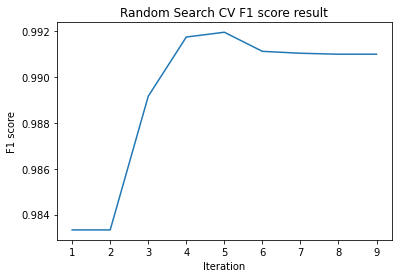

In [358]:
# plotting the various mean f1 scores
labels = grid_cfl.cv_results_['params']
x_axis = range(1,10)
y_axis = grid_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

print("BEST MODEL -- ", grid_cfl.best_estimator_)

In [359]:
x_cfl = LogisticRegression(C=0.1)
x_cfl.fit(df,y_d2.values.ravel())

LogisticRegression(C=0.1)

In [360]:
# Predicting the intermediation output for the test dataset before giving it to the meta classifier
def test_dataset(num_of_models, model_list, X_ensemble_test):
    test_output_list = []
    test_df = []
    
    # Predict output for the test set
    for i in range(num_of_models):
        model = model_list[i]
        output = model.predict(X_ensemble_test)
        test_output_list.append(output)
    
    # Zip the output of the test set two form a dataset
    for i in range(len(test_output_list[0])):
        output = []
        for j in range(num_of_models):
            output.append(test_output_list[j][i])
        test_df.append(output)   
    test_df = pd.DataFrame(test_df)
    return test_df

Test F1 score: 0.8760903228925057


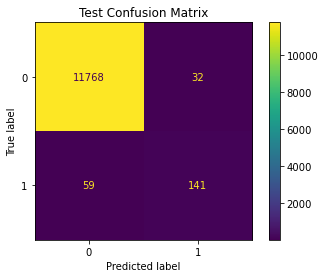

In [361]:
test_df = test_dataset(num_of_models, model_list, X_ensemble_test)
y_test_pred = x_cfl.predict(test_df)
print("Test F1 score:", f1_score(y_ensemble_test, y_test_pred, average='macro'))

plot1 = plot_confusion_matrix(x_cfl, test_df, y_ensemble_test) 
plot1.ax_.set_title('Test Confusion Matrix')

plt.show()

### Results
- 10 DT Models - 0.853355893965031
- 20 DT Models - 0.8531305921677959
- 50 DT Models - 0.8631384259778475
- 75 DT Models - 0.8760903228925057

## Median Imputed Data without FE

In [362]:
X_train, X_ensemble_test, y_train, y_ensemble_test = train_test_split(data_df, y_true, stratify=y_true, test_size=0.2)

dataset_d1, dataset_d2, y_d1, y_d2 = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5)

print(dataset_d1.shape, dataset_d2.shape, X_ensemble_test.shape)

(24000, 149) (24000, 149) (12000, 149)


In [363]:
high_correlated_columns = ['sensor45_measure', 'sensor32_measure', 'sensor46_measure', 'sensor47_measure', 'sensor67_measure']
for column in high_correlated_columns:
    if column in X_train.columns:
        dataset_d1 = dataset_d1.drop([column],axis=1)
        dataset_d2 = dataset_d2.drop([column],axis=1)
        X_ensemble_test = X_ensemble_test.drop([column],axis=1)
        
dataset_d1 = dataset_d1.drop(['sensor64_histogram_bin5'],axis=1)
dataset_d2 = dataset_d2.drop(['sensor64_histogram_bin5'],axis=1)
X_ensemble_test = X_ensemble_test.drop(['sensor64_histogram_bin5'],axis=1)

In [364]:
median_values = dataset_d1.median()
columns = dataset_d1.columns
dataset_d1 = dataset_d1.fillna(median_values)
dataset_d2 = dataset_d2.fillna(median_values)
X_ensemble_test = X_ensemble_test.fillna(median_values)

print(dataset_d1.shape, dataset_d2.shape, X_ensemble_test.shape)

(24000, 143) (24000, 143) (12000, 143)


In [365]:
dataset_d1 = pd.DataFrame(dataset_d1)
dataset_d2 = pd.DataFrame(dataset_d2)
X_ensemble_test = pd.DataFrame(X_ensemble_test)

dataset_d1.columns = columns
dataset_d2.columns = columns
X_ensemble_test.columns = columns

In [366]:
mnmx_scaler = MinMaxScaler()
columns = dataset_d1.columns

dataset_d1 = pd.DataFrame(mnmx_scaler.fit_transform(dataset_d1))
dataset_d2 = pd.DataFrame(mnmx_scaler.transform(dataset_d2))
X_ensemble_test = pd.DataFrame(mnmx_scaler.transform(X_ensemble_test))

dataset_d1.columns = columns
dataset_d2.columns = columns
X_ensemble_test.columns = columns

In [383]:
# Number of models here is a hyper parameter and has been tried with mutiple values and the results are below
num_of_models = 75
model_list, df = ensemble_model_DT(num_of_models, dataset_d1, y_d1, dataset_d2, y_d2)

Generating Samples Done
Fitting Base Models Done
Predict on Dataset 2 Done
Formed Meta Dataset Done


In [384]:
# Logistic Regression as the meta classifier and it is hyper paramterized with the GridSearch CV

x_cfl = LogisticRegression()

params={
    'C':[10 ** x for x in range(-5, 4)]
}
grid_cfl=GridSearchCV(x_cfl, param_grid=params, n_jobs=-1, scoring='f1')
grid_cfl.fit(df, y_d2.values.ravel())

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000]})

{'C': 1e-05} : 0.9833333333333332
{'C': 0.0001} : 0.9833333333333332
{'C': 0.001} : 0.9893749999999999
{'C': 0.01} : 0.9920833333333332
{'C': 0.1} : 0.9918333333333333
{'C': 1} : 0.9914166666666666
{'C': 10} : 0.9911666666666668
{'C': 100} : 0.991125
{'C': 1000} : 0.991125
BEST MODEL --  LogisticRegression(C=0.01)


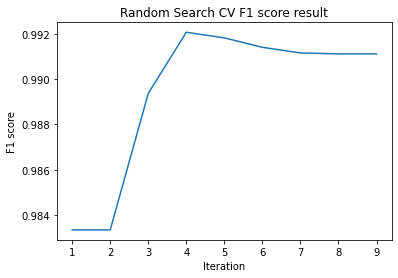

In [385]:
# plotting the various mean f1 scores

labels = grid_cfl.cv_results_['params']
x_axis = range(1,10)
y_axis = grid_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

print("BEST MODEL -- ", grid_cfl.best_estimator_)

In [392]:
x_cfl = LogisticRegression(C=0.1)
x_cfl.fit(df,y_d2.values.ravel())

LogisticRegression(C=0.1)

Test F1 score: 0.8699066890239725


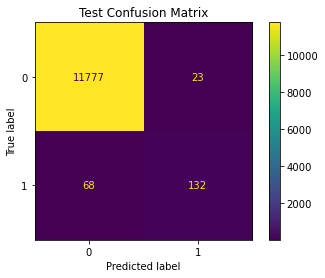

In [393]:
test_df = test_dataset(num_of_models, model_list, X_ensemble_test)
y_test_pred = x_cfl.predict(test_df)
print("Test F1 score:", f1_score(y_ensemble_test, y_test_pred, average='macro'))

plot1 = plot_confusion_matrix(x_cfl, test_df, y_ensemble_test) 
plot1.ax_.set_title('Test Confusion Matrix')

plt.show()

- 10 DT Models - 0.8399217860838921
- 20 DT Models - 0.8584360327484646
- 50 DT Models - 0.8778061312810195
- 75 DT Models - 0.8699066890239725

## Comments 

### From both the ensemble models we see that they are not very close to the Voting Classifiers when Feature Engineering has not been applied. This shows that our Feature Engineering has contributed to the final results and improving the F1 score.

## -------------------------------------------------------------------------------------------------------------------------------------

# Ensemble model 

## with feature engineered data for KNN imputed dataset 

In [394]:
X_train, X_ensemble_test, y_train, y_ensemble_test = train_test_split(data_df, y_true, stratify=y_true, test_size=0.2)

dataset_d1, dataset_d2, y_d1, y_d2 = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5)

print(dataset_d1.shape, dataset_d2.shape, X_ensemble_test.shape)

(24000, 149) (24000, 149) (12000, 149)


In [395]:
high_correlated_columns = ['sensor45_measure', 'sensor32_measure', 'sensor46_measure', 'sensor47_measure', 'sensor67_measure']
for column in high_correlated_columns:
    if column in X_train.columns:
        dataset_d1 = dataset_d1.drop([column],axis=1)
        dataset_d2 = dataset_d2.drop([column],axis=1)
        X_ensemble_test = X_ensemble_test.drop([column],axis=1)
        
dataset_d1 = dataset_d1.drop(['sensor64_histogram_bin5'],axis=1)
dataset_d2 = dataset_d2.drop(['sensor64_histogram_bin5'],axis=1)
X_ensemble_test = X_ensemble_test.drop(['sensor64_histogram_bin5'],axis=1)

In [396]:
knn_imputer = KNNImputer(weights="distance")
columns = dataset_d1.columns
dataset_d1 = knn_imputer.fit_transform(dataset_d1)
dataset_d2 = knn_imputer.transform(dataset_d2)
X_ensemble_test = knn_imputer.transform(X_ensemble_test)

print(dataset_d1.shape, dataset_d2.shape, X_ensemble_test.shape)

(24000, 143) (24000, 143) (12000, 143)


In [397]:
dataset_d1 = pd.DataFrame(dataset_d1)
dataset_d2 = pd.DataFrame(dataset_d2)
X_ensemble_test = pd.DataFrame(X_ensemble_test)

dataset_d1.columns = columns
dataset_d2.columns = columns
X_ensemble_test.columns = columns

In [399]:
T_SVD = TruncatedSVD(n_components=4, n_iter=20)

dataset1_tSVD = T_SVD.fit_transform(dataset_d1)
dataset2_tSVD = T_SVD.transform(dataset_d2)
X_test_tSVD = T_SVD.fit_transform(X_ensemble_test)

print(dataset1_tSVD.shape, dataset2_tSVD.shape, X_test_tSVD.shape)

(24000, 4) (24000, 4) (12000, 4)


In [400]:
for i in range(4):
    dataset_d1["SVD_"+str(i)] = dataset1_tSVD[:,i]
    dataset_d2["SVD_"+str(i)] = dataset2_tSVD[:,i]
    X_ensemble_test["SVD_"+str(i)] = X_test_tSVD[:,i]

print(dataset_d1.shape, dataset_d2.shape, X_ensemble_test.shape)

(24000, 147) (24000, 147) (12000, 147)


In [401]:
column_names = dict()

for column in dataset_d1.columns:
    value = column.split("_")
    if value[1] == 'histogram':
        if value[0] not in column_names:
            column_names[value[0]] = []
        column_names[value[0]].append(column)
        
print(column_names)

{'sensor7': ['sensor7_histogram_bin2', 'sensor7_histogram_bin3', 'sensor7_histogram_bin4', 'sensor7_histogram_bin5', 'sensor7_histogram_bin6', 'sensor7_histogram_bin7', 'sensor7_histogram_bin8', 'sensor7_histogram_bin9'], 'sensor24': ['sensor24_histogram_bin5', 'sensor24_histogram_bin6', 'sensor24_histogram_bin7', 'sensor24_histogram_bin8'], 'sensor25': ['sensor25_histogram_bin0', 'sensor25_histogram_bin1', 'sensor25_histogram_bin2', 'sensor25_histogram_bin3', 'sensor25_histogram_bin4', 'sensor25_histogram_bin5', 'sensor25_histogram_bin6', 'sensor25_histogram_bin7', 'sensor25_histogram_bin8'], 'sensor26': ['sensor26_histogram_bin0', 'sensor26_histogram_bin1', 'sensor26_histogram_bin2', 'sensor26_histogram_bin3', 'sensor26_histogram_bin4', 'sensor26_histogram_bin5', 'sensor26_histogram_bin6', 'sensor26_histogram_bin7', 'sensor26_histogram_bin8', 'sensor26_histogram_bin9'], 'sensor64': ['sensor64_histogram_bin1', 'sensor64_histogram_bin2', 'sensor64_histogram_bin3', 'sensor64_histogram_b

In [402]:
dataset_d1 = add_average_bin_feature(dataset_d1, column_names)
dataset_d2 = add_average_bin_feature(dataset_d2, column_names)
X_ensemble_test = add_average_bin_feature(X_ensemble_test, column_names)

In [403]:
mnmx_scaler = MinMaxScaler()
columns = dataset_d1.columns

dataset_d1 = pd.DataFrame(mnmx_scaler.fit_transform(dataset_d1))
dataset_d2 = pd.DataFrame(mnmx_scaler.transform(dataset_d2))
X_ensemble_test = pd.DataFrame(mnmx_scaler.transform(X_ensemble_test))

dataset_d1.columns = columns
dataset_d2.columns = columns
X_ensemble_test.columns = columns

In [440]:
# Number of models here is a hyper parameter and has been tried with mutiple values and the results are below
num_of_models = 75
model_list, df = ensemble_model_DT(num_of_models, dataset_d1, y_d1, dataset_d2, y_d2)

Generating Samples Done
Fitting Base Models Done
Predict on Dataset 2 Done
Formed Meta Dataset Done


In [442]:
# Logistic Regression as the meta classifier and it is hyper paramterized with the GridSearch CV

x_cfl = LogisticRegression()

params={
    'C':[10 ** x for x in range(-5, 4)]
}
grid_cfl=GridSearchCV(x_cfl, param_grid=params, n_jobs=-1,scoring='f1')
grid_cfl.fit(df, y_d2.values.ravel())

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000]})

{'C': 1e-05} : 0.9833333333333332
{'C': 0.0001} : 0.9833333333333332
{'C': 0.001} : 0.9894583333333333
{'C': 0.01} : 0.9914166666666666
{'C': 0.1} : 0.9925
{'C': 1} : 0.9922083333333334
{'C': 10} : 0.9918333333333333
{'C': 100} : 0.99175
{'C': 1000} : 0.99175
BEST MODEL --  LogisticRegression(C=0.1)


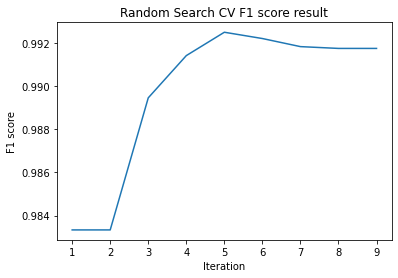

In [443]:
# plotting the various mean f1 scores

labels = grid_cfl.cv_results_['params']
x_axis = range(1,10)
y_axis = grid_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

print("BEST MODEL -- ", grid_cfl.best_estimator_)

In [452]:
x_cfl = LogisticRegression(C=0.1)
x_cfl.fit(df,y_d2.values.ravel())

LogisticRegression(C=0.1)

Test F1 score: 0.875233877404997


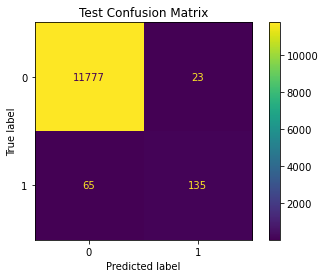

In [453]:
test_df = test_dataset(num_of_models, model_list, X_ensemble_test)
y_test_pred = x_cfl.predict(test_df)
print("Test F1 score:", f1_score(y_ensemble_test, y_test_pred, average='macro'))

plot1 = plot_confusion_matrix(x_cfl, test_df, y_ensemble_test) 
plot1.ax_.set_title('Test Confusion Matrix')

plt.show()

### Results 
- 10 DT Model - 0.8706245599369046
- 20 DT Model - 0.8787366046249295
- 50 DT Model - 0.8817634631713474
- 75 DT Model - 0.875233877404997

#### Median Imputed Data

In [454]:
X_train, X_ensemble_test, y_train, y_ensemble_test = train_test_split(data_df, y_true, stratify=y_true, test_size=0.2)

dataset_d1, dataset_d2, y_d1, y_d2 = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5)

print(dataset_d1.shape, dataset_d2.shape, X_ensemble_test.shape)

(24000, 149) (24000, 149) (12000, 149)


In [455]:
high_correlated_columns = ['sensor45_measure', 'sensor32_measure', 'sensor46_measure', 'sensor47_measure', 'sensor67_measure']
for column in high_correlated_columns:
    if column in X_train.columns:
        dataset_d1 = dataset_d1.drop([column],axis=1)
        dataset_d2 = dataset_d2.drop([column],axis=1)
        X_ensemble_test = X_ensemble_test.drop([column],axis=1)
        
dataset_d1 = dataset_d1.drop(['sensor64_histogram_bin5'],axis=1)
dataset_d2 = dataset_d2.drop(['sensor64_histogram_bin5'],axis=1)
X_ensemble_test = X_ensemble_test.drop(['sensor64_histogram_bin5'],axis=1)

In [456]:
median_values = dataset_d1.median()
columns = dataset_d1.columns
dataset_d1 = dataset_d1.fillna(median_values)
dataset_d2 = dataset_d2.fillna(median_values)
X_ensemble_test = X_ensemble_test.fillna(median_values)

print(dataset_d1.shape, dataset_d2.shape, X_ensemble_test.shape)

dataset_d1 = pd.DataFrame(dataset_d1)
dataset_d2 = pd.DataFrame(dataset_d2)
X_ensemble_test = pd.DataFrame(X_ensemble_test)

dataset_d1.columns = columns
dataset_d2.columns = columns
X_ensemble_test.columns = columns

(24000, 143) (24000, 143) (12000, 143)


In [457]:
column_names = dict()

for column in dataset_d1.columns:
    value = column.split("_")
    if value[1] == 'histogram':
        if value[0] not in column_names:
            column_names[value[0]] = []
        column_names[value[0]].append(column)
        
print(column_names)

{'sensor7': ['sensor7_histogram_bin2', 'sensor7_histogram_bin3', 'sensor7_histogram_bin4', 'sensor7_histogram_bin5', 'sensor7_histogram_bin6', 'sensor7_histogram_bin7', 'sensor7_histogram_bin8', 'sensor7_histogram_bin9'], 'sensor24': ['sensor24_histogram_bin5', 'sensor24_histogram_bin6', 'sensor24_histogram_bin7', 'sensor24_histogram_bin8'], 'sensor25': ['sensor25_histogram_bin0', 'sensor25_histogram_bin1', 'sensor25_histogram_bin2', 'sensor25_histogram_bin3', 'sensor25_histogram_bin4', 'sensor25_histogram_bin5', 'sensor25_histogram_bin6', 'sensor25_histogram_bin7', 'sensor25_histogram_bin8'], 'sensor26': ['sensor26_histogram_bin0', 'sensor26_histogram_bin1', 'sensor26_histogram_bin2', 'sensor26_histogram_bin3', 'sensor26_histogram_bin4', 'sensor26_histogram_bin5', 'sensor26_histogram_bin6', 'sensor26_histogram_bin7', 'sensor26_histogram_bin8', 'sensor26_histogram_bin9'], 'sensor64': ['sensor64_histogram_bin1', 'sensor64_histogram_bin2', 'sensor64_histogram_bin3', 'sensor64_histogram_b

In [458]:
dataset_d1 = add_average_bin_feature(dataset_d1, column_names)
dataset_d2 = add_average_bin_feature(dataset_d2, column_names)
X_ensemble_test = add_average_bin_feature(X_ensemble_test, column_names)

In [459]:
mnmx_scaler = MinMaxScaler()
columns = dataset_d1.columns

dataset_d1 = pd.DataFrame(mnmx_scaler.fit_transform(dataset_d1))
dataset_d2 = pd.DataFrame(mnmx_scaler.transform(dataset_d2))
X_ensemble_test = pd.DataFrame(mnmx_scaler.transform(X_ensemble_test))

dataset_d1.columns = columns
dataset_d2.columns = columns
X_ensemble_test.columns = columns

In [508]:
# Number of models here is a hyper parameter and has been tried with mutiple values and the results are below
num_of_models = 75
model_list, df = ensemble_model_DT(num_of_models, dataset_d1, y_d1, dataset_d2, y_d2)

Generating Samples Done
Fitting Base Models Done
Predict on Dataset 2 Done
Formed Meta Dataset Done


In [509]:
# Logistic Regression as the meta classifier and it is hyper paramterized with the GridSearch CV

x_cfl = LogisticRegression()

params={
    'C':[10 ** x for x in range(-5, 4)]
}
grid_cfl=GridSearchCV(x_cfl, param_grid=params, n_jobs=-1, scoring='f1')
grid_cfl.fit(df, y_d2.values.ravel())

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000]})

{'C': 1e-05} : 0.9833333333333332
{'C': 0.0001} : 0.9833333333333332
{'C': 0.001} : 0.9900833333333333
{'C': 0.01} : 0.992875
{'C': 0.1} : 0.9930833333333334
{'C': 1} : 0.9926250000000001
{'C': 10} : 0.9925416666666667
{'C': 100} : 0.9925833333333334
{'C': 1000} : 0.9925833333333334
BEST MODEL --  LogisticRegression(C=0.1)


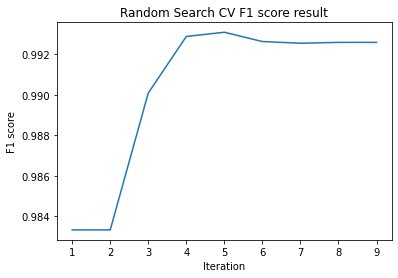

In [510]:
# plotting the various mean f1 scores

labels = grid_cfl.cv_results_['params']
x_axis = range(1,10)
y_axis = grid_cfl.cv_results_['mean_test_score']
for i, label in enumerate(labels):
    print(label, ":", y_axis[i])
    
plt.xlabel('Iteration')
plt.ylabel('F1 score')
plt.title('Random Search CV F1 score result')
plt.plot(x_axis, y_axis)

print("BEST MODEL -- ", grid_cfl.best_estimator_)

In [519]:
x_cfl = LogisticRegression(C=0.1)
x_cfl.fit(df,y_d2.values.ravel())

LogisticRegression(C=0.1)

Test F1 score: 0.8746894043266515


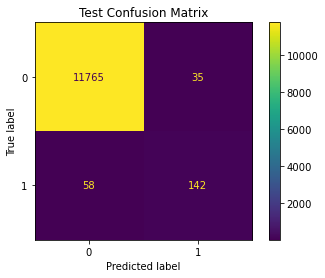

In [520]:
test_df = test_dataset(num_of_models, model_list, X_ensemble_test)
y_test_pred = x_cfl.predict(test_df)
print("Test F1 score:", f1_score(y_ensemble_test, y_test_pred, average='macro'))

plot1 = plot_confusion_matrix(x_cfl, test_df, y_ensemble_test) 
plot1.ax_.set_title('Test Confusion Matrix')

plt.show()

### Results
- 10 DT Models - 0.8431698281983553
- 20 DT Models - 0.877661205676942
- 50 DT Models - 0.8805020358973197
- 75 DT Models - 0.8746894043266515

### The Ensemble Models with FE dataset along with Median/KNN based imputation provided good results close to the RF classifiers but did not reach the F1 score of the Voting Classifiers.

# Take aways from Modelling

- With every model, we saw improvement in the F1 scores.
- Few sensors like Sensor 85, 35, 82 ,9 and Bin 1 of Sensor 25 are the top features that added to classification.
- Bin Average Feature which was added as Feature Engineering feature has good amount of importance with few of the features being in the top 25 features.
- We observed that the Voting and Stacking Classifiers performed the best when used the best hyper parameters of the dataset based on the imputation.
- Overall Voting Classifier with median imputation had the highest F1 score of ~0.90 over all other Models including Ensemble models. Other Models like Stacking and XG boost were not far with scores of ~0.89

In [540]:
GREEN  = '\033[92m'
END = '\033[0m'
BOLD = '\033[1m'

print(BOLD+"The Highlighted Rows are the ones with higher F1 score."+END)

table = PrettyTable()
table.field_names = ["Model", "Parameter", "Imputation" ,"Train F1 Score", "CV F1 score", "Test F1 Score"]
table.add_row(["KNN","manhattan, n=3, distance","Median", 1.0, 0.839, 0.847])
table.add_row(["KNN","manhattan, n=4, distance","KNN imputer", 1.0, 0.845, 0.831])
table.add_row(["","","","","",""])
table.add_row([BOLD+"Random Forest"+END,"d=100, n=1500","Median", 1.0, 0.908, BOLD+GREEN+"0.889"+END])
table.add_row(["Random Forest","d=100, n=1000","KNN imputer", 1.0, 0.903, 0.879])
table.add_row(["","","","","",""])
table.add_row([BOLD+"XG Boost"+END,"ss=1, d=5, n=2000, lr=0.05, colsam_tree=0.5","Median", 1.0, 0.913, BOLD+GREEN+"0.887"+END])
table.add_row(["XG Boost","ss=0.5, d=10, n=2000, lr=0.2, colsam_tree=0.3","KNN imputer", 1.0, 0.914, 0.877])
table.add_row(["","","","","",""])
table.add_row([BOLD+"Stacking Classifier"+END,"RF, XBG, KNN, meta=KNN","Median", 1.0, 0.915, BOLD+GREEN+"0.894"+END])
table.add_row(["Stacking Classifier","RF, XBG, KNN, meta=KNN","KNN imputer", 1.0, 0.906, 0.891])
table.add_row(["","","","","",""])
table.add_row([BOLD+"Voting Classifier"+END,"RF, XBG, KNN","Median", 1.0, 0.916, BOLD+GREEN+"0.898"+END])
table.add_row(["Voting Classifier","RF, XBG, KNN","KNN imputer", 1.0, 0.904, 0.889])
table.add_row(["","","","","",""])
table.add_row(["Ensemble Models without FE","10 DT + Logistic Regression","Median", "0.99", "-", 0.839])
table.add_row(["Ensemble Models without FE","20 DT + Logistic Regression","Median", "0.99", "-", 0.858])
table.add_row(["Ensemble Models without FE","50 DT + Logistic Regression","Median", "0.99", "-", 0.877])
table.add_row(["Ensemble Models without FE","75 DT + Logistic Regression","Median", "0.99", "-", 0.869])
table.add_row(["","","","","",""])
table.add_row(["Ensemble Models without FE","10 DT + Logistic Regression","KNN imputer", "0.99", "-", 0.853])
table.add_row(["Ensemble Models without FE","20 DT + Logistic Regression","KNN imputer", "0.99", "-", 0.853])
table.add_row(["Ensemble Models without FE","50 DT + Logistic Regression","KNN imputer", "0.99", "-", 0.863])
table.add_row(["Ensemble Models without FE","75 DT + Logistic Regression","KNN imputer", "0.99", "-", 0.876])
table.add_row(["","","","","",""])
table.add_row(["Ensemble Models with FE","10 DT + Logistic Regression","Median", "0.99", "-", 0.843])
table.add_row(["Ensemble Models with FE","20 DT + Logistic Regression","Median", "0.99", "-", 0.877])
table.add_row([BOLD+"Ensemble Models with FE"+END,"50 DT + Logistic Regression","Median", "0.99", "-", BOLD+GREEN+"0.881"+END])
table.add_row(["Ensemble Models with FE","75 DT + Logistic Regression","Median", "0.99", "-", 0.874])
table.add_row(["","","","","",""])
table.add_row(["Ensemble Models with FE","10 DT + Logistic Regression","KNN imputer", "0.99", "-", 0.871])
table.add_row(["Ensemble Models with FE","20 DT + Logistic Regression","KNN imputer", "0.99", "-", 0.878])
table.add_row([BOLD+"Ensemble Models with FE"+END,"50 DT + Logistic Regression","KNN imputer", "0.99", "-", BOLD+GREEN+"0.881"+END])
table.add_row(["Ensemble Models with FE","75 DT + Logistic Regression","KNN imputer", "0.99", "-", 0.875])

table._max_width = {"Model":30, "Parameter":30, "Imputation":30 ,"Train F1 Score":5, "CV F1 score":5, "Test F1 Score":5}
print(table)


The Highlighted Rows are the ones with higher F1 score.
+----------------------------+--------------------------------+-------------+----------------+-------------+---------------+
|           Model            |           Parameter            |  Imputation | Train F1 Score | CV F1 score | Test F1 Score |
+----------------------------+--------------------------------+-------------+----------------+-------------+---------------+
|            KNN             |    manhattan, n=3, distance    |    Median   |      1.0       |    0.839    |     0.847     |
|            KNN             |    manhattan, n=4, distance    | KNN imputer |      1.0       |    0.845    |     0.831     |
|                            |                                |             |                |             |               |
|       Random Forest        |         d=100, n=1500          |    Median   |      1.0       |    0.908    |     0.889     |
|       Random Forest        |         d=100, n=1000          | KNN i

## Deployment 

### The solution has been deployed on the following website
- http://ec2-52-15-225-42.us-east-2.compute.amazonaws.com:8080/index